### <center>**Reading and Cleaning Annotation Data for Custom PyTorch Object Detection**</center> 

In [ ]:
from IPython import get_ipython

ipython = get_ipython()
if ipython is not None:
    ipython.cache_size = 0  # disable cache

In [1]:
# Import necessary packages
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # restrict cuda to gpu 0
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # set CUDA kernel to synchronous
import json
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion(); # interactive mode

##### Load annotation data into dataframe

In [2]:
# Function for reading JSON as dictionary
def read_json(filename: str) -> dict:
    try:
        with open(filename, "r") as f:
            data = json.load(f)
    except Exception as e:
        raise Exception(f"Reading {filename} file encountered an error: {e}")
    return data

# Function to create a DataFrame from a list of records
def create_dataframe(data: list) -> pd.DataFrame:
    # Normalize the column levels and create a DataFrame
    return pd.json_normalize(data)

# Main function to iterate over files in directory and add to df
def main():
    # Assign directory and empty list for collecting records
    directory = "C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotations/"  # annotation directory
    records = []
    
    # Iterate over files in directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            # Read the JSON file as python dictionary 
            data = read_json(filename=f)
        
            # Create the dataframe for the array items in annotations key 
            df = create_dataframe(data=data['annotations'])
            df.insert(loc=0, column='img_name', value=f'{f[-30:-5]}.JPG')
        
            df.rename(columns={
                "img_name": "img_name",
                "name": "label",
                "bounding_box.h": "bbox_height",
                "bounding_box.w": "bbox_width",
                "bounding_box.x": "bbox_x_topLeft",
                "bounding_box.y": "bbox_y_topLeft",
                "polygon.paths": "polygon_path"
            }, inplace=True)
            
            # Append the records to the list
            records.append(df)
        else:
            print(f"Skipping non-file: {filename}")

    # Concatenate all records into a single DataFrame
    annos_df = pd.concat(records, ignore_index=True)

    # Convert x, y, h, w to xmin, ymin, xmax, ymax
    annos_df['xmin'] = annos_df['bbox_x_topLeft']
    annos_df['ymin'] = annos_df['bbox_y_topLeft']
    annos_df['xmax'] = annos_df['bbox_x_topLeft'] + annos_df['bbox_width']
    annos_df['ymax'] = annos_df['bbox_y_topLeft'] + annos_df['bbox_height']
  
    # Drop unnecessary columns 
    annos_df = annos_df.drop(columns=['bbox_height', 'bbox_width', 'bbox_x_topLeft', 
                                      'bbox_y_topLeft', 'id', 'slot_names', 'polygon_path'])
        
    return annos_df

if __name__ == "__main__":
    df = main()
    print(df.head())

                        img_name label     xmin     ymin     xmax     ymax
0  DJI_20211215103949_0003_Z.JPG   Hen   626.35  1538.24  1249.31  1924.61
1  DJI_20211215103949_0003_Z.JPG  MALL  2083.69  1894.40  2770.84  2339.91
2  DJI_20211215103957_0004_Z.JPG  MALL  2779.02  1336.17  3263.37  2020.32
3  DJI_20211215103957_0004_Z.JPG   Hen  1734.63  1649.99  2547.94  1978.95
4  DJI_20211215105707_0002_Z.JPG   Hen  2677.59  1822.57  3072.69  2188.04


##### Pre-process annotation dataframe

In [3]:
# Get the unique image names
unique_img_names = df['img_name'].unique()

invalid_img_names = []
for img_name in unique_img_names:
    img_path = f'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Images/{img_name}'
    img = Image.open(img_path)
    if img.size == (5184, 3888):
        invalid_img_names.append(img_name)

# load curated images list from file
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/curated_images.txt', 'r') as f:
    curated_images = f.read().splitlines()

# remove any invalid images from curated images list
curated_images = [img_name for img_name in curated_images if img_name not in invalid_img_names]

# filter df to include only curated images
df = df[df['img_name'].isin(curated_images)]

img_classes_to_remove = ['WTDE', 'TURT', 'NUTR', 'ANHI', 'CAGO', 
                         'DCCO', 'GWFG', 'GBHE', 'COGA', 'PBGR'] # remove images with these classes

for class_label in img_classes_to_remove:
    # Get all image names with the class
    images_with_class = df[df['label'] == class_label]['img_name'].unique()

    # Remove all rows for img
    df = df[~df['img_name'].isin(images_with_class)]

# remove images containing only hens
hen_images_no_other_class = df[(df['label'] == 'Hen') & (~df['img_name'].isin(df[df['label'] != 'Hen']['img_name']))]['img_name'].unique()
df = df[~df['img_name'].isin(hen_images_no_other_class)]

# Separate classes with less than 100 instances
class_counts = df['label'].value_counts()
other_classes = class_counts[class_counts < 100].index.tolist()
positive_classes = class_counts[class_counts >= 100].index.tolist()

# print class counts for each label
print("Number of instances per class in cleaned dataset:")
for label in df['label'].unique():
    print(f'{label}: {len(df[df["label"] == label])}')

# print other and positive classes
print()
print(f'Other classes: {other_classes}')
print(f'Positive classes: {positive_classes}')

# remove images with other classes
for class_label in other_classes:
    # Get all image names with the class
    images_with_class = df[df['label'] == class_label]['img_name'].unique()

    # Remove all rows for img
    df = df[~df['img_name'].isin(images_with_class)]

# encode labels as int (reserve 0 for 'background')
df['target'] = pd.Categorical(df['label']).codes + 1

# filter out images with invalid bounding boxes
df = df.groupby('img_name').filter(lambda x: ((x['xmin'] < x['xmax']) & (x['ymin'] < x['ymax'])).all())

# clip any bbox coordinates that are outside image bounds i.e., xmin < 0, ymin < 0, xmax > img_width, ymax > img_height
df['img_path'] = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Images/' + df['img_name']
df['img_width'] = df['img_path'].map(lambda x: Image.open(x).size[0])
df['img_height'] = df['img_path'].map(lambda x: Image.open(x).size[1])
df['xmin'] = df['xmin'].clip(lower=0)
df['ymin'] = df['ymin'].clip(lower=0)
df['xmax'] = df[['xmax', 'img_width']].min(axis=1)
df['ymax'] = df[['ymax', 'img_height']].min(axis=1)

# Create a dictionary using df['label'] as the keys and df['target'] as the values
label_dict = dict(zip(df['target'], df['label']))

# Drop the original 'label' column from df
df = df.drop(['label'], axis=1)

# Rename 'target' column to 'label'
df.rename(columns={'target': 'label'}, inplace=True)

# Save df as csv in directory
df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv', index=False)

Number of instances per class in cleaned dataset:
Hen: 2054
MALL: 837
NSHO: 234
AMCO: 431
GWTE: 622
GADW: 917
RNDU: 1151
NOPI: 585
REDH: 210
BUFF: 75

Other classes: ['BUFF']
Positive classes: ['Hen', 'RNDU', 'GADW', 'MALL', 'GWTE', 'NOPI', 'AMCO', 'NSHO', 'REDH']


##### Filter images after pre-processing

In [4]:
# Store unique img_names in filtered df as array
img_names = df['img_name'].unique().tolist()

# Create a new directory called 'filtered_images'
filtered_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images'
if not os.path.exists(filtered_dir):
    os.makedirs(filtered_dir)
else:
    for file in os.listdir(filtered_dir):
        os.remove(os.path.join(filtered_dir, file))

# Copy images in img_names to new directory
for img in img_names:
    shutil.copy2(f'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Images/{img}', filtered_dir)

### <center>**Transform and Augment Image and Annotation Data for Custom PyTorch Object Detection**</center> 

In [5]:
# import necessary packages
import numpy as np
from collections import defaultdict, Counter
import torchvision
torchvision.disable_beta_transforms_warning()
import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
from torchvision import transforms as _transforms, tv_tensors
import torchvision.transforms.v2 as T
import utils

In [6]:
class MAVdroneDataset(torch.utils.data.Dataset):
    """Dataset Loader for Waterfowl Drone Imagery"""

    def __init__(self, csv_file, root_dir, transforms):
        """
        Arguments:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory containing all images.
            transforms (callable): Transformation to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transforms = transforms
        self.unique_image_names = self.df['img_name'].unique()

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = self.unique_image_names[idx]

        # Isolate first row to prevent multiple instances of the same image
        row = self.df[self.df['img_name'] == image_name].iloc[0]

        image_path = os.path.join(self.root_dir, row['img_name'])
        image = Image.open(image_path).convert('RGB')
        image = np.array(image, dtype=np.uint8)
        image = torch.from_numpy(image).permute(2, 0, 1)  # Convert to Tensor

        # Bounding boxes and labels
        boxes = self.df[self.df['img_name'] == image_name][['xmin', 'ymin', 'xmax', 'ymax']].values 
        labels = self.df[self.df['img_name'] == image_name]['label'].values

        labels = torch.as_tensor(labels, dtype=torch.int64)  # (n_objects)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Calculate area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Assume no crowd annotations
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        # Create target dictionary
        target = {
            'boxes': tv_tensors.BoundingBoxes(boxes, format=tv_tensors.BoundingBoxFormat.XYXY, canvas_size=(image.shape[1], image.shape[2])),
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(self.unique_image_names)

##### Data transformation function

In [7]:
def get_transform(train: bool):
    """
    Args:
        train (bool): Whether the transform is for training or validation/testing.
    """
    transforms_list = [T.ToImage()]
    
    if train:
        transforms_list.append(T.RandomIoUCrop(min_scale=0.5, max_scale=1.25)) 
        transforms_list.append(T.RandomApply([T.ColorJitter(brightness=0.2, contrast=0.25, saturation=0.2, hue=0.01)], p=0.5))
        transforms_list.append(T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.3))  
        transforms_list.append(T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3))
        transforms_list.append(T.RandomHorizontalFlip(0.5))
        transforms_list.append(T.ClampBoundingBoxes())  # Clamp bounding boxes to image boundaries
        transforms_list.append(T.SanitizeBoundingBoxes())
    
    transforms_list.append(
        T.Resize(
            size=(810,),
            max_size=1440,
            interpolation=torchvision.transforms.InterpolationMode.BICUBIC
        )
    )
    transforms_list.append(
        T.ToDtype(
            dtype=torch.float32,
            scale=True
        )
    )
    transforms_list.append(
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    )
    
    return T.Compose(transforms_list)

##### Helper functions for plotting image and annotations

In [8]:
# classes are values in label_dict
classes = list(label_dict.values())

# reverse label dictionary for mapping predictions to classes
rev_label_dict = {v: k for k, v in label_dict.items()}

# distinct colors 
bbox_colors = [
    "#FF0000",  # Red
    "#00FF00",  # Green
    "#FFFF00",  # Yellow
    "#FF00FF",  # Magenta
    "#00FFFF",  # Cyan
    "#FFC0CB",  # Pink
    "#FFA500",  # Orange
    "#800080",  # Purple
    "#FFFFFF",  # White
    "#FFD700",  # Gold
]

# label color map for plotting color-coded boxes by class
label_color_map = {k: bbox_colors[i] for i, k in enumerate(label_dict.keys())}

# function for reshaping boxes 
def get_box(boxes):
    boxes = np.array(boxes)
    boxes = boxes.astype('float').reshape(-1, 4)
    if boxes.shape[0] == 1 : return boxes
    return np.squeeze(boxes)


# function for plotting image
def img_show(image, ax = None, figsize = (6, 9)):
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    ax.xaxis.tick_top()
    ax.imshow(image)
    return ax
 

def plot_bbox(ax, boxes, labels):
    # add box to the image and use label_color_map to color-code by bounding box class if exists else 'black'
    ax.add_patch(plt.Rectangle((boxes[:, 0], boxes[:, 1]), boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1],
                    fill = False,
                    color = label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 
                    linewidth = 1.25))
    # add label text to bounding box using label_dict if label exists else labels
    ax.text(boxes[:, 2], boxes[:, 3], 
            (label_dict[labels.item()] if labels.item() in label_dict else labels.item()),
            fontsize = 8,
            bbox = dict(facecolor = 'white', alpha = 0.8, pad = 0, edgecolor = 'none'),
            color = 'black')


# function for plotting all boxes and labels on the image using get_polygon, img_show, and plot_mask functions
def plot_detections(image, boxes, labels, ax = None):
    ax = img_show(image.permute(1, 2, 0), ax = ax)
    for i in range(len(boxes)):
        box = get_box(boxes[i])
        plot_bbox(ax, box, labels[i])

##### Plot sample batch to confirm data loads and transforms correctly

In [9]:
# Load sample batch of data to custom PyTorch Dataset and Transform
sample_dataset = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv', 
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images', 
                                transforms = get_transform(train = True))

sample_data_loader = torch.utils.data.DataLoader(sample_dataset, batch_size = 8, shuffle=True, 
                                                collate_fn = utils.collate_fn, num_workers = 0)

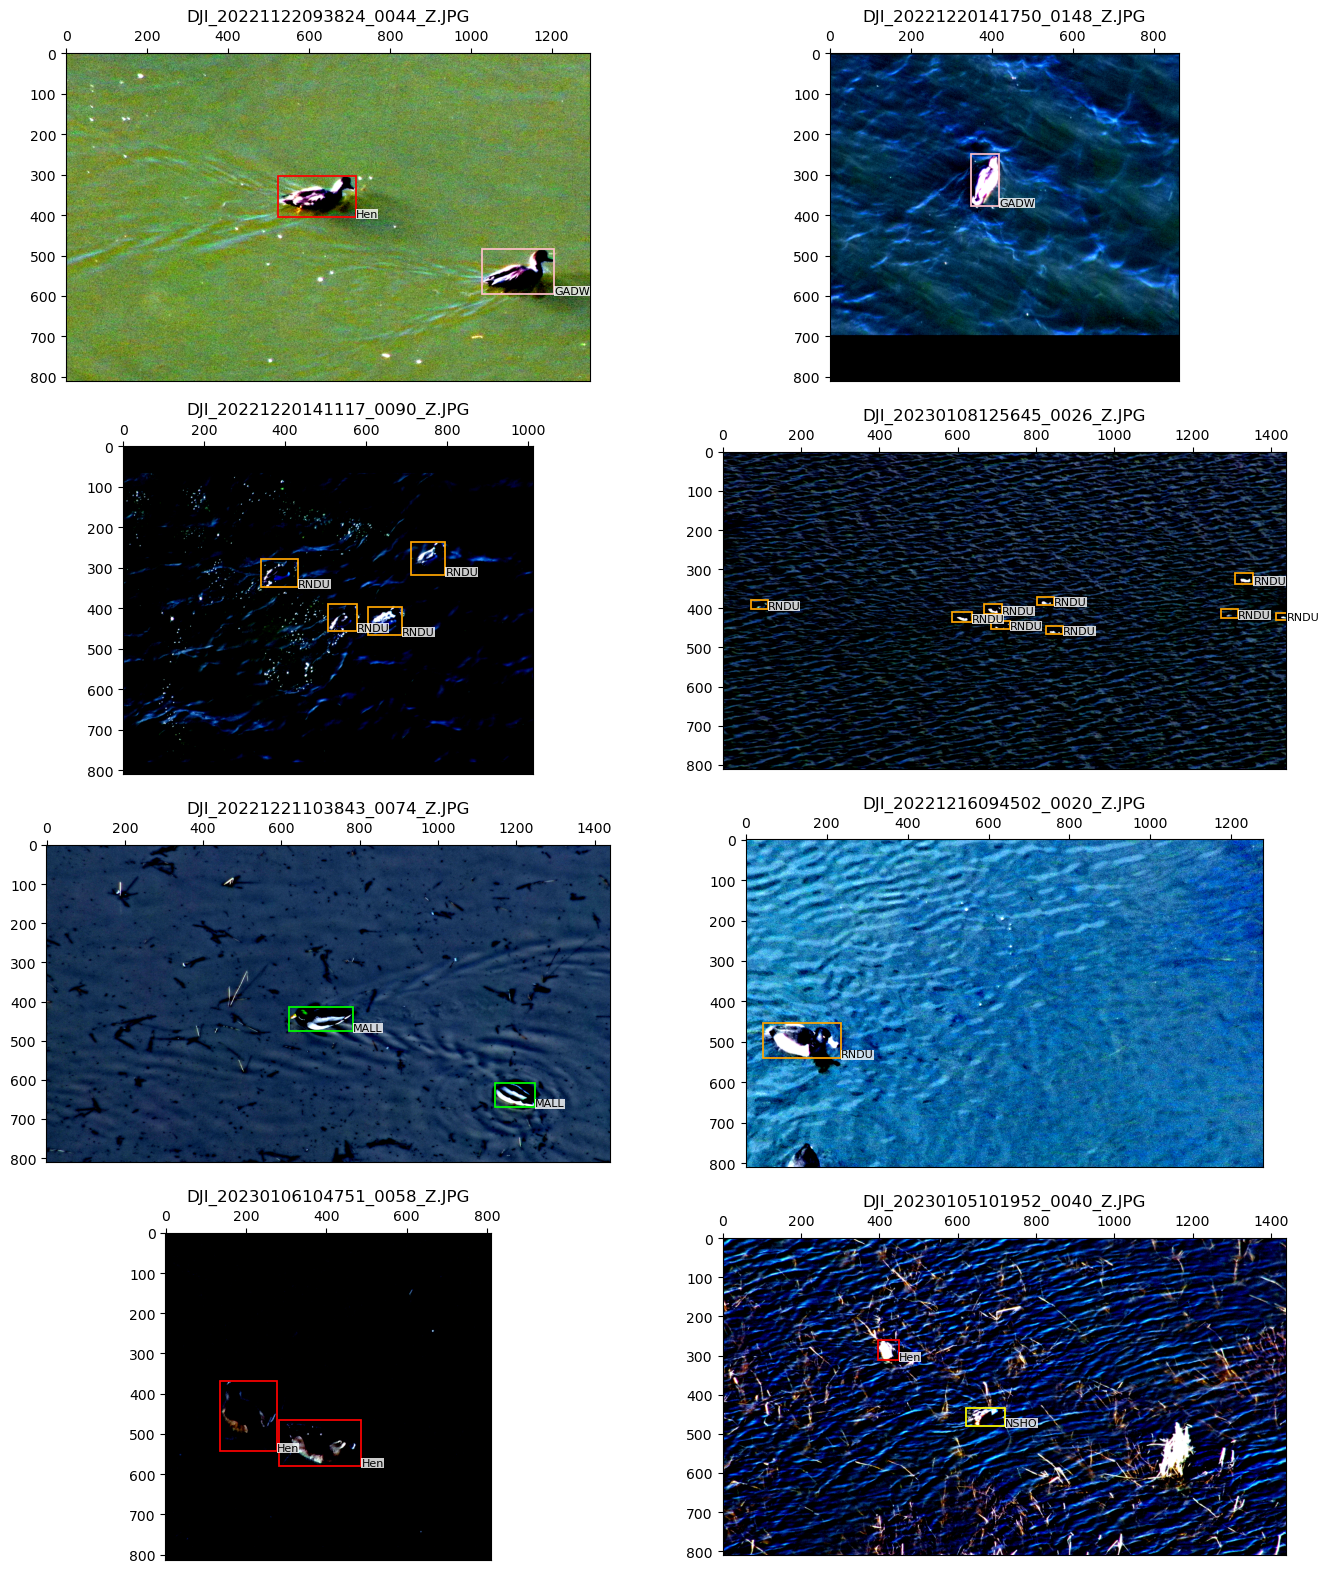

In [10]:
# store images and annotation targets from sample batch
batch = next(iter(sample_data_loader))
images, targets = batch
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

images = [np.clip(image, 0, 1) for image in images]

# Plot all samples from batch in a grid of subplots
plt.figure(figsize=(16, int(sample_data_loader.batch_size) * 5))
for i in range(int(sample_data_loader.batch_size)):
    ax = plt.subplot(int(sample_data_loader.batch_size), 2, 1 + i)
    plot_detections(images[i], targets[i]['boxes'], targets[i]['labels'], ax=ax)
    # Query the dataset to get the image name for the given image_id
    image_id = targets[i]['image_id'].item()  # Convert tensor to integer
    image_name = sample_dataset.unique_image_names[image_id]
    plt.title(image_name)

plt.show()

#### Use stratified sampling to split multi-label dataset into train, val, test sets

In [11]:
from sklearn.model_selection import StratifiedKFold

# Set random number generator for reproducible data splits
rng = np.random.default_rng(np.random.MT19937(np.random.SeedSequence(6666)))

# Group annotations by image
image_groups = df.groupby('img_name')

# Create a dictionary to store the class distribution for each image
image_class_distribution = {}

# Populate the dictionary with class distributions
for image_name, group in image_groups:
    labels = group['label'].tolist()
    image_class_distribution[image_name] = labels

# Create a list of all image names and their corresponding labels
all_images = list(image_class_distribution.keys())
all_labels = [image_class_distribution[image] for image in all_images]

# Use the most frequent label for each image for stratification
representative_labels = [max(set(labels), key=labels.count) for labels in all_labels]

# Define the split ratios
train_ratio = 0.8
val_ratio = 0.15
test_ratio = 0.05

# Perform stratified split using StratifiedKFold
skf = StratifiedKFold(n_splits=int(1/test_ratio), shuffle=True, random_state=6666)

train_val_indices, test_indices = next(skf.split(all_images, representative_labels))

# Further split train+val into train and validation sets
train_val_images = [all_images[idx] for idx in train_val_indices]
train_val_labels = [representative_labels[idx] for idx in train_val_indices]

skf_val = StratifiedKFold(n_splits=int(1/(val_ratio/(train_ratio + val_ratio))), shuffle=True, random_state=6666)
train_indices, val_indices = next(skf_val.split(train_val_images, train_val_labels))

# Map image names to unique indices
image_to_unique_index = {image: idx for idx, image in enumerate(df['img_name'].unique())}

# Create lists of unique indices for each split
train_indices = [image_to_unique_index[train_val_images[idx]] for idx in train_indices]
val_indices = [image_to_unique_index[train_val_images[idx]] for idx in val_indices]
test_indices = [image_to_unique_index[all_images[idx]] for idx in test_indices]

# Function to get class distribution
def get_class_distribution(images, image_class_distribution):
    class_counts = defaultdict(int)
    for image in images:
        for label in image_class_distribution[image]:
            class_counts[label] += 1
    return class_counts

# Get train, val, and test images
train_images = [all_images[idx] for idx in train_indices]
val_images = [all_images[idx] for idx in val_indices]
test_images = [all_images[idx] for idx in test_indices]

train_class_distribution = get_class_distribution(train_images, image_class_distribution)
val_class_distribution = get_class_distribution(val_images, image_class_distribution)
test_class_distribution = get_class_distribution(test_images, image_class_distribution)

class_indices = {label: [] for label in df['label'].unique()}

for idx, row in df.iterrows():
    class_indices[row['label']].append(idx)

train_class_distribution = {k: v / len(class_indices[k]) for k, v in train_class_distribution.items()}
val_class_distribution = {k: v / len(class_indices[k]) for k, v in val_class_distribution.items()}
test_class_distribution = {k: v / len(class_indices[k]) for k, v in test_class_distribution.items()}

print("Train class distribution:", dict(sorted(train_class_distribution.items())))
print("Validation class distribution:", dict(sorted(val_class_distribution.items())))
print("Test class distribution:", dict(sorted(test_class_distribution.items())))

Train class distribution: {1: 0.8491879350348028, 2: 0.8298800436205016, 3: 0.8036006546644845, 4: 0.7966915688367129, 5: 0.7873357228195937, 6: 0.788034188034188, 7: 0.7564102564102564, 8: 0.8, 9: 0.7960467205750225}
Validation class distribution: {1: 0.11600928074245939, 2: 0.13304252998909488, 3: 0.14729950900163666, 4: 0.15474919957310565, 5: 0.15890083632019117, 6: 0.1623931623931624, 7: 0.19230769230769232, 8: 0.14761904761904762, 9: 0.15992812219227315}
Test class distribution: {1: 0.03480278422273782, 2: 0.03707742639040349, 3: 0.049099836333878884, 4: 0.04855923159018143, 5: 0.053763440860215055, 6: 0.04957264957264957, 7: 0.05128205128205128, 8: 0.05238095238095238, 9: 0.0440251572327044}


#### Create weighted random sampler to handle class imbalances during training

In [12]:
def calculate_class_weights(labels, hen_label_int, background_label_int):
    # Count the occurrences of each class
    class_counts = Counter(labels)
    
    # Remove the "Hen" class from the counts
    hen_count = class_counts.pop(hen_label_int, None)
    
    # Identify the count for the second most-frequent class
    second_most_frequent_class_count = max(class_counts.values())
    
    # Calculate the weight for the "Hen" class
    hen_weight = second_most_frequent_class_count / hen_count if hen_count else 1.0

    # Assign weights to all classes (non-Hen)
    class_weights = {label: sum(class_counts.values()) / count for label, count in class_counts.items()}
    
    # Add weight for the "Hen" class and background before normalization
    class_weights[hen_label_int] = hen_weight
    class_weights[background_label_int] = 0.1  

    # Normalize all weights (including background) by dividing by the maximum weight
    max_weight = max(class_weights.values())
    class_weights = {label: weight / max_weight for label, weight in class_weights.items()}
    
    return class_weights

# Store train labels for each image
train_labels = [label for image in train_images for label in image_class_distribution[image]]

# Calculate class weights dynamically
hen_label_int = [key for key, value in label_dict.items() if value == 'Hen'][0]  # Get the integer label for "Hen"
background_label_int = 0  # Assuming background is class 0
class_weights = calculate_class_weights(train_labels, hen_label_int, background_label_int)

# Ensure the background label is included for printing
all_labels = sorted(set([background_label_int] + train_labels))

# Convert class weights to a list in the correct order (with background as the first element)
train_class_weights = [class_weights[label] for label in all_labels]
train_class_weights = torch.tensor(train_class_weights, dtype=torch.float32)

# Print class counts and weights (including background)
print("Train class instances and weights: ")
# Print background label explicitly
print(f"Background: weight = {class_weights[background_label_int]}")
for label in all_labels:
    if label == background_label_int:
        continue
    print(f"{label_dict[label]}: count = {train_labels.count(label)}, weight = {class_weights[label]}")
print()

# Calculate sample weights for each image in the training dataset
train_sample_weights = []
for image_name in train_images:
    labels = image_class_distribution[image_name]
    sample_weight = sum(train_class_weights[all_labels.index(label)] for label in labels) / len(labels)
    train_sample_weights.append(sample_weight)

# Create WeightedRandomSampler
train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=train_sample_weights, num_samples=len(train_sample_weights), replacement=True
)

Train class instances and weights: 
Background: weight = 0.004232804232804233
AMCO: count = 366, weight = 0.4590163934426229
GADW: count = 761, weight = 0.22076215505913271
GWTE: count = 491, weight = 0.3421588594704685
Hen: count = 1493, weight = 0.025118985601236102
MALL: count = 659, weight = 0.2549317147192716
NOPI: count = 461, weight = 0.36442516268980474
NSHO: count = 177, weight = 0.9491525423728814
REDH: count = 168, weight = 1.0
RNDU: count = 886, weight = 0.18961625282167044



#### Calculate Anchor Sizes and Aspect Ratios of Transformed Data

In [13]:
# from sklearn.cluster import KMeans

# resized_bounding_boxes = []

# for images, targets in sample_data_loader:
#     for target in targets:
#         for box in target['boxes']:
#             resized_bounding_boxes.append(box)

# # Convert to numpy array
# resized_bounding_boxes = np.array(resized_bounding_boxes)

# # Print the resized bounding box dimensions
# print(resized_bounding_boxes[:5])

# # Convert to [width, height] format
# widths = resized_bounding_boxes[:, 2] - resized_bounding_boxes[:, 0]
# heights = resized_bounding_boxes[:, 3] - resized_bounding_boxes[:, 1]
# bounding_boxes_wh = np.stack((widths, heights), axis=1)

# # filter out bounding boxes with width or height less than 25
# bounding_boxes_wh = bounding_boxes_wh[(bounding_boxes_wh[:, 0] >= 25) & (bounding_boxes_wh[:, 1] >= 25)]

# # Perform k-means clustering to find anchor sizes
# num_clusters = 5  # Number of anchor sizes
# kmeans = KMeans(n_clusters=num_clusters, random_state=6666).fit(bounding_boxes_wh)
# anchor_sizes = kmeans.cluster_centers_

# # Print the anchor sizes
# print("Anchor Sizes (width, height):")
# print(anchor_sizes)

# # Determine aspect ratios from the anchor sizes
# anchor_aspect_ratios = anchor_sizes[:, 0] / anchor_sizes[:, 1]

# # Print the aspect ratios
# print("Anchor Aspect Ratios:")
# print(anchor_aspect_ratios)

# sorted_widths = np.sort(bounding_boxes_wh[:, 0])
# sorted_heights = np.sort(bounding_boxes_wh[:, 1])

# print("Smallest Widths:")
# print(sorted_widths[:5])
# print("Largest Widths:")
# print(sorted_widths[-5:])
# print("Smallest Heights:")
# print(sorted_heights[:5])
# print("Largest Heights:")
# print(sorted_heights[-5:])

#### Configure Custom RetinaNet with ResNet FPN

In [14]:
import torch
import torch.nn as nn
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.retinanet import RetinaNetClassificationHead, RetinaNetRegressionHead
from torchvision.models.detection.anchor_utils import AnchorGenerator
import torchvision.models.detection._utils as det_utils
from torchvision.ops import sigmoid_focal_loss, FrozenBatchNorm2d
import torchvision.ops.boxes as box_ops
from typing import Callable, Dict, List, Optional, Tuple
from pt_soft_nms import batched_soft_nms


def _sum(x: List[torch.Tensor]) -> torch.Tensor:
    res = x[0]
    for i in x[1:]:
        res = res + i
    return res


class CustomRetinaNetClassificationHead(RetinaNetClassificationHead):
    def __init__(self, in_channels, num_anchors, num_classes, alpha=0.25, gamma_loss=2.0, prior_probability=0.01, 
                 norm_layer: Optional[Callable[..., nn.Module]] = None, dropout_prob=0.25, class_weights=None, label_smoothing=0.1):
        super().__init__(in_channels, num_anchors, num_classes, prior_probability, norm_layer)
        self.alpha = alpha
        self.gamma_loss = gamma_loss
        self.dropout = nn.Dropout(p=dropout_prob)
        self.class_weights = class_weights
        self.label_smoothing = label_smoothing

    def compute_loss(self, targets, head_outputs, matched_idxs):
        losses = []

        cls_logits = head_outputs["cls_logits"]

        for i, (targets_per_image, cls_logits_per_image, matched_idxs_per_image) in enumerate(zip(targets, cls_logits, matched_idxs)):
            # determine only the foreground
            foreground_idxs_per_image = matched_idxs_per_image >= 0
            num_foreground = foreground_idxs_per_image.sum()

            # create the target classification
            gt_classes_target = torch.zeros_like(cls_logits_per_image)
            gt_classes_target += self.label_smoothing / (self.num_classes - 1) # smoothing for negative classes
            gt_classes_target[
                foreground_idxs_per_image,
                targets_per_image["labels"][matched_idxs_per_image[foreground_idxs_per_image]],
            ] = 1.0 - self.label_smoothing # smoothing for positive classes

            # find indices for which anchors should be ignored
            valid_idxs_per_image = matched_idxs_per_image != self.BETWEEN_THRESHOLDS

            # get the class weights for the valid indices
            if self.class_weights is not None:
                valid_labels = targets_per_image["labels"][matched_idxs_per_image[valid_idxs_per_image]]
                weights = self.class_weights.to(valid_labels.device)[valid_labels]
            else:
                weights = torch.ones(cls_logits_per_image[valid_idxs_per_image].shape[0], dtype=torch.float32, device=cls_logits_per_image.device)

            # compute the classification loss with custom alpha, gamma_loss, and class weights
            losses.append(
                (sigmoid_focal_loss(
                    cls_logits_per_image[valid_idxs_per_image],
                    gt_classes_target[valid_idxs_per_image],
                    alpha=self.alpha,
                    gamma=self.gamma_loss,
                    reduction="none",
                ) * weights.unsqueeze(1)).sum() / max(1, num_foreground)
            )

        return _sum(losses) / len(targets)
    
    def forward(self, x):
        all_cls_logits = []
        for features in x:
            cls_logits = self.conv(features)
            cls_logits = self.dropout(cls_logits)  # Apply dropout
            cls_logits = self.cls_logits(cls_logits)

            # Permute classification output from (N, A * K, H, W) to (N, HWA, K).
            N, _, H, W = cls_logits.shape
            cls_logits = cls_logits.view(N, -1, self.num_classes, H, W)
            cls_logits = cls_logits.permute(0, 3, 4, 1, 2)
            cls_logits = cls_logits.reshape(N, -1, self.num_classes)  # Size=(N, HWA, K)

            all_cls_logits.append(cls_logits)


        return torch.cat(all_cls_logits, dim=1)


class CustomRetinaNetRegressionHead(RetinaNetRegressionHead):
    def __init__(self, in_channels, num_anchors, norm_layer: Optional[Callable[..., nn.Module]] = None, _loss_type="smooth_l1", beta_loss=0.5, lambda_loss=1.0, dropout_prob=0.25):
        super().__init__(in_channels, num_anchors, norm_layer)
        self._loss_type = _loss_type
        self.beta_loss = beta_loss # beta < 1 helps counter early plateauing
        self.lambda_loss = lambda_loss # lambda > 1 places more emphasis on localization loss
        self.dropout = nn.Dropout(p=dropout_prob)
    
    def compute_loss(self, targets, head_outputs, anchors, matched_idxs):
        # type: (List[Dict[str, torch.Tensor]], Dict[str, torch.Tensor], List[torch.Tensor], List[torch.Tensor]) -> torch.Tensor
        losses = []

        bbox_regression = head_outputs["bbox_regression"]

        for targets_per_image, bbox_regression_per_image, anchors_per_image, matched_idxs_per_image in zip(
            targets, bbox_regression, anchors, matched_idxs
        ):
            # determine only the foreground indices, ignore the rest
            foreground_idxs_per_image = torch.where(matched_idxs_per_image >= 0)[0]
            num_foreground = foreground_idxs_per_image.numel()

            # select only the foreground boxes
            matched_gt_boxes_per_image = targets_per_image["boxes"][matched_idxs_per_image[foreground_idxs_per_image]]
            bbox_regression_per_image = bbox_regression_per_image[foreground_idxs_per_image, :]
            anchors_per_image = anchors_per_image[foreground_idxs_per_image, :]

            # compute the loss
            losses.append(
                    det_utils._box_loss(
                    self._loss_type,
                    self.box_coder,
                    anchors_per_image,
                    matched_gt_boxes_per_image,
                    bbox_regression_per_image,
                    cnf={'beta': self.beta_loss}, 
                ) * self.lambda_loss / max(1, num_foreground)
            )

        return _sum(losses) / max(1, len(targets))
    
    def forward(self, x):
        all_bbox_regression = []
        for features in x:
            bbox_regression = self.conv(features)
            bbox_regression = self.dropout(bbox_regression)  # Apply dropout
            bbox_regression = self.bbox_reg(bbox_regression)

            # Permute bbox regression output from (N, 4 * A, H, W) to (N, HWA, 4).
            N, _, H, W = bbox_regression.shape
            bbox_regression = bbox_regression.view(N, -1, 4, H, W)
            bbox_regression = bbox_regression.permute(0, 3, 4, 1, 2)
            bbox_regression = bbox_regression.reshape(N, -1, 4)  # Size=(N, HWA, 4)

            all_bbox_regression.append(bbox_regression)

        return torch.cat(all_bbox_regression, dim=1)

class CustomRetinaNet(RetinaNet):
    def __init__(self, backbone, num_classes, min_size, max_size, image_mean, image_std, score_thresh, detections_per_img, 
                 fg_iou_thresh, bg_iou_thresh, topk_candidates, nms_score, nms_sigma):
        super().__init__(backbone, num_classes=num_classes, 
                         min_size=min_size, 
                         max_size=max_size, 
                         image_mean=image_mean, 
                         image_std=image_std, 
                         score_thresh=score_thresh, 
                         nms_thresh=None, 
                         detections_per_img=detections_per_img, 
                         fg_iou_thresh=fg_iou_thresh, 
                         bg_iou_thresh=bg_iou_thresh, 
                         topk_candidates=topk_candidates)
        # Store the new NMS parameters.
        self.nms_score = nms_score
        self.nms_sigma = nms_sigma

    def postprocess_detections(self, head_outputs, anchors, image_shapes):
        # type: (Dict[str, List[torch.Tensor]], List[List[torch.Tensor]], List[Tuple[int, int]]) -> List[Dict[str, torch.Tensor]]
        class_logits = head_outputs["cls_logits"]
        box_regression = head_outputs["bbox_regression"]

        num_images = len(image_shapes)

        detections: List[Dict[str, torch.Tensor]] = []

        for index in range(num_images):
            box_regression_per_image = [br[index] for br in box_regression]
            logits_per_image = [cl[index] for cl in class_logits]
            anchors_per_image, image_shape = anchors[index], image_shapes[index]

            image_boxes = []
            image_scores = []
            image_labels = []

            for box_regression_per_level, logits_per_level, anchors_per_level in zip(
                box_regression_per_image, logits_per_image, anchors_per_image
            ):
                num_classes = logits_per_level.shape[-1]

                # remove low scoring boxes
                scores_per_level = torch.sigmoid(logits_per_level).flatten()
                keep_idxs = scores_per_level > self.score_thresh
                scores_per_level = scores_per_level[keep_idxs]
                topk_idxs = torch.where(keep_idxs)[0]

                # keep only topk scoring predictions
                num_topk = det_utils._topk_min(topk_idxs, self.topk_candidates, 0)
                scores_per_level, idxs = scores_per_level.topk(num_topk)
                topk_idxs = topk_idxs[idxs]

                anchor_idxs = torch.div(topk_idxs, num_classes, rounding_mode="floor")
                labels_per_level = topk_idxs % num_classes

                boxes_per_level = self.box_coder.decode_single(
                    box_regression_per_level[anchor_idxs], anchors_per_level[anchor_idxs]
                )
                boxes_per_level = box_ops.clip_boxes_to_image(boxes_per_level, image_shape)

                image_boxes.append(boxes_per_level)
                image_scores.append(scores_per_level)
                image_labels.append(labels_per_level)

            image_boxes = torch.cat(image_boxes, dim=0)
            image_scores = torch.cat(image_scores, dim=0)
            image_labels = torch.cat(image_labels, dim=0)

            # Apply custom soft non-maximum suppression using the new parameters.
            keep = batched_soft_nms(image_boxes, image_scores, image_labels, sigma=self.nms_sigma, score_threshold=self.nms_score)

            # Sort by score descending and limit to max detections per image
            keep = keep[image_scores[keep].argsort(descending=True)]
            keep = keep[: self.detections_per_img]

            detections.append(
                {
                    "boxes": image_boxes[keep],
                    "scores": image_scores[keep],
                    "labels": image_labels[keep],
                }
            )

        return detections

In [15]:
def get_retinanet_model(depth, num_classes=10, min_size=810, max_size=1440, image_mean=[0, 0, 0], image_std=[1, 1, 1], score_thresh=0.1,
                        detections_per_img=200, fg_iou_thresh=0.6, bg_iou_thresh=0.5, topk_candidates=200, alpha=0.75, gamma_loss=3.0, 
                        class_weights=None, beta_loss=0.5, lambda_loss=1.5, dropout_prob=0.25, nms_score=0.25, nms_sigma=0.5):
    
    trainable_backbone_layers = 0  # set constant, adjust later with function

    # Create the backbone with FPN
    if depth == 18:
        backbone = resnet_fpn_backbone(backbone_name='resnet18', 
                                       weights=torchvision.models.ResNet18_Weights.DEFAULT, 
                                       trainable_layers=trainable_backbone_layers)
    elif depth == 34:
        backbone = resnet_fpn_backbone(backbone_name='resnet34', 
                                       weights=torchvision.models.ResNet34_Weights.DEFAULT,
                                       trainable_layers=trainable_backbone_layers)
    elif depth == 50:
        backbone = resnet_fpn_backbone(backbone_name='resnet50', 
                                       weights=torchvision.models.ResNet50_Weights.DEFAULT,
                                       trainable_layers=trainable_backbone_layers)
    elif depth == 101:
        backbone = resnet_fpn_backbone(backbone_name='resnet101', 
                                       weights=torchvision.models.ResNet101_Weights.DEFAULT, 
                                       trainable_layers=trainable_backbone_layers)
    elif depth == 152:
        backbone = resnet_fpn_backbone(backbone_name='resnet152', 
                                       weights=torchvision.models.ResNet152_Weights.DEFAULT, 
                                       trainable_layers=trainable_backbone_layers)
    else:
        raise ValueError("Unsupported model depth")

    # Create the RetinaNet model with the custom backbone.
    model = CustomRetinaNet(backbone, 
                            num_classes=num_classes,
                            min_size=min_size,  # same size as resize in transform to keep aspect ratio
                            max_size=max_size,
                            image_mean=image_mean,
                            image_std=image_std,
                            score_thresh=score_thresh, 
                            detections_per_img=detections_per_img,
                            fg_iou_thresh=fg_iou_thresh,
                            bg_iou_thresh=bg_iou_thresh,
                            topk_candidates=topk_candidates,
                            nms_score=nms_score,
                            nms_sigma=nms_sigma
                           )

    # Replace the classification head with the custom one
    in_channels = model.head.classification_head.cls_logits.in_channels
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head = CustomRetinaNetClassificationHead(in_channels, 
                                                                       num_anchors, 
                                                                       num_classes, 
                                                                       alpha=alpha, 
                                                                       gamma_loss=gamma_loss, 
                                                                       dropout_prob=dropout_prob,
                                                                       class_weights=class_weights)

    # Replace the regression head with the custom one
    model.head.regression_head = CustomRetinaNetRegressionHead(in_channels, 
                                                               num_anchors, 
                                                               _loss_type="smooth_l1",
                                                               beta_loss=beta_loss,
                                                               lambda_loss=lambda_loss,
                                                               dropout_prob=dropout_prob)

    model.anchor_generator = AnchorGenerator(sizes=((24, 32, 40), (48, 64, 80), (96, 128, 160), (192, 256, 320), (472, 536, 600)), 
                                             aspect_ratios=((0.75, 1.15, 1.8), (0.75, 1.15, 1.8), (0.75, 1.15, 1.8), (0.75, 1.15, 1.8), (0.75, 1.15, 1.8)))

    return model

print(get_retinanet_model(depth=50))

CustomRetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(

##### Clean up Jupyter environment

In [16]:
del all_images, all_labels, ax, background_label_int, batch, bbox_colors, class_counts, class_indices, class_label, class_weights, curated_images, df, file, group, hen_images_no_other_class, hen_label_int, i, idx, image_class_distribution, image_groups, image_id, image_name, images, images_with_class, img, img_classes_to_remove, img_name, img_names, img_path, invalid_img_names, label, labels, other_classes, positive_classes, representative_labels, row, sample_data_loader, sample_dataset, sample_weight, targets, test_class_distribution, test_images, test_ratio, train_class_distribution, train_images, train_labels, train_ratio, train_sample_weights, train_val_images, train_val_indices, train_val_labels, unique_img_names, val_class_distribution, val_images, val_ratio

### <center>**Tune Model Hyperparameters using Ray Tune**</center> 

##### Class for tuning RetinaNet

In [ ]:
import ray
from ray import tune, train
from ray.tune.schedulers import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB
from ray.tune.search import ConcurrencyLimiter
from datetime import datetime
import torch
import gc
from pathlib import Path
import ray.cloudpickle as pickle
from concurrent.futures import ThreadPoolExecutor
import random
from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter
from engine_gradientAccumulation import train_one_epoch, evaluate
from coco_utils import get_coco_api_from_dataset

# Set random seed for reproducible training
def set_seed(seed):
    import torch, random
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)


def extract_per_class_metrics(coco_eval, coco_gt):
    per_class_metrics = {}

    # Create a list of category IDs in the order they appear in the evaluation results
    cat_ids = list(coco_gt.cats.keys())
    cat_id_to_index = {cat_id: idx for idx, cat_id in enumerate(cat_ids)}

    for cat_id, idx in cat_id_to_index.items():
        try:
            precision = coco_eval.coco_eval['bbox'].eval['precision'][:, :, idx, 0, 2]
            recall = coco_eval.coco_eval['bbox'].eval['recall'][:, idx, 0, 2]

            per_class_metrics[cat_id] = {
                'precision': precision.mean(),
                'recall': recall.mean()
            }
        except IndexError as e:
            print(f"IndexError for category ID {cat_id}: {e}")
            continue

    return per_class_metrics


def adjust_trainable_layers(model, trainable_layers):
    """
    Adjust the trainable layers in the RetinaNet backbone (model.backbone.body).
    Unfreeze the last `trainable_layers` residual blocks and replace their FrozenBatchNorm2d layers.
    When trainable_layers=5, also unfreeze conv1 and replace bn1 with trainable BatchNorm2d.
    """
    def convert_frozen_bn(frozen_bn):
        device = frozen_bn.running_mean.device  # Get the device of the frozen BN layer
        num_features = frozen_bn.weight.shape[0]
        bn = torch.nn.BatchNorm2d(num_features)
        bn = bn.to(device)
        # Initialize with existing stats.
        bn.running_mean = frozen_bn.running_mean.clone()
        bn.running_var = frozen_bn.running_var.clone()
        torch.nn.init.normal_(bn.weight, mean=1.0, std=0.02)
        torch.nn.init.constant_(bn.bias, 0)
        return bn

    # Collect backbone blocks.
    backbone_layers = []
    for layer_name in ['layer1', 'layer2', 'layer3', 'layer4']:
        if hasattr(model.backbone.body, layer_name):
            backbone_layers.append(getattr(model.backbone.body, layer_name))
    
    if trainable_layers > 5:
        print(f"Requested trainable_layers ({trainable_layers}) exceeds available layers (5). Using 5 instead.")
        trainable_layers = 5

    # Unfreeze the last `trainable_layers` blocks.
    for block in backbone_layers[-trainable_layers:]:
        for param in block.parameters():
            param.requires_grad = True

    # Replace FrozenBatchNorm2d layers in these blocks.
    for name, module in model.backbone.body.named_modules():
        if isinstance(module, FrozenBatchNorm2d):
            if 'layer' in name:
                layer_num = int(name.split('.')[0][-1])
                if layer_num > (4 - trainable_layers):
                    parent_name = '.'.join(name.split('.')[:-1])
                    module_name = name.split('.')[-1]
                    parent = dict(model.backbone.body.named_modules())[parent_name]
                    setattr(parent, module_name, convert_frozen_bn(module))
            elif trainable_layers == 5 and name == 'bn1':
                model.backbone.body.bn1 = convert_frozen_bn(module)
                model.backbone.body.conv1.weight.requires_grad = True


class RetinaNetTuner:
    def __init__(self, num_samples, restore_path=""):
        self.num_samples = num_samples
        self.restore_path = restore_path

    def create_coco_datasets(self, train_dataset, val_dataset, test_dataset):
        with ThreadPoolExecutor(max_workers=3) as executor:
            train_future = executor.submit(get_coco_api_from_dataset, train_dataset)
            val_future = executor.submit(get_coco_api_from_dataset, val_dataset)
            test_future = executor.submit(get_coco_api_from_dataset, test_dataset)
            train_coco_ds = train_future.result()
            val_coco_ds = val_future.result()
            test_coco_ds = test_future.result()
        return train_coco_ds, val_coco_ds, test_coco_ds

    def train_lr_finder(self, config):
        class CustomTrainDataLoaderIter(TrainDataLoaderIter):
            def inputs_labels_from_batch(self, batch_data):
                inputs = [image.to('cuda:0') for image in batch_data[0]]
                labels = [{k: v.to('cuda:0') for k, v in t.items()} for t in batch_data[1]]
                return inputs, labels

        class CustomValDataLoaderIter(ValDataLoaderIter):
            def __iter__(self):
                self._iterator = iter(self.data_loader)
                self.run_counter = 0
                return self

            def __next__(self):
                try:
                    self.run_counter += 1
                    return super().__next__()
                except StopIteration:
                    # Reset if exhausted and then return next batch
                    self._iterator = iter(self.data_loader)
                    self.run_counter = 0
                    return super().__next__()

            def inputs_labels_from_batch(self, batch_data):
                inputs = [image.to("cuda:0") for image in batch_data[0]]
                labels = [{k: v.to("cuda:0") for k, v in t.items()} for t in batch_data[1]]
                return inputs, labels

        dataset_train = ray.get(config["dataset_train_ref"])
        dataset_train = torch.utils.data.Subset(dataset_train, train_indices)
        data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=8,
                                                        sampler=self.config["train_sampler"],
                                                        collate_fn=utils.collate_fn,
                                                        num_workers=0, pin_memory=True)
        train_iter = CustomTrainDataLoaderIter(data_loader_train)

        data_loader_val = ray.get(config["data_loader_val_ref"])
        val_iter = CustomValDataLoaderIter(data_loader_val)

        model = get_retinanet_model(
            depth=self.config["resnet_depth"],
            num_classes=len(self.config["class_weights"]),
            score_thresh=self.config["score_thresh"],
            detections_per_img=200,
            fg_iou_thresh=self.config["fg_iou_thresh"],
            bg_iou_thresh=self.config["bg_iou_thresh"],
            topk_candidates=200,
            alpha=self.config["alpha"],
            gamma_loss=self.config["gamma_loss"],
            class_weights=None,
            beta_loss=self.config["beta_loss"],
            lambda_loss=self.config["lambda_loss"],
            dropout_prob=self.config["dropout"],
            nms_score=self.config["nms_score"],
            nms_sigma=self.config["nms_sigma"]
        ).to('cuda:0')

        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(
            params, lr=1e-7, momentum=self.config["momentum"], weight_decay=self.config["weight_decay"]
        )

        grad_scaler = torch.GradScaler()

        class CustomLRFinder(LRFinder):
            def __init__(self, model, optimizer, criterion, device=None, amp_backend="native", amp_config=None, grad_scaler=None):
                super().__init__(model, optimizer, criterion, device)
                self.amp_backend = amp_backend
                self.amp_config = amp_config
                self.grad_scaler = grad_scaler or torch.GradScaler()

            def _train_batch(self, train_iter, accumulation_steps, non_blocking_transfer=True):
                self.model.train()
                total_loss = 0

                self.optimizer.zero_grad()
                for _ in range(accumulation_steps):
                    inputs, labels = next(train_iter)
                    inputs, labels = self._move_to_device(inputs, labels, non_blocking=non_blocking_transfer)

                    with torch.autocast(device_type="cuda:0"):
                        outputs = self.model(inputs, labels)
                        loss = sum(loss for loss in outputs.values())
                    loss /= accumulation_steps
                    self.grad_scaler.scale(loss).backward()
                    total_loss += loss
                self.grad_scaler.step(self.optimizer)
                self.grad_scaler.update()
                return total_loss.item()

            def _validate(self, val_iter, non_blocking_transfer=True):
                self.model.train()   # FORCE training mode here!
                inputs, labels = next(val_iter)
                inputs, labels = self._move_to_device(inputs, labels, non_blocking=non_blocking_transfer)
                with torch.no_grad(), torch.autocast(device_type="cuda:0"):
                    outputs = self.model(inputs, labels)
                    loss = sum(loss for loss in outputs.values())
                return loss.item()

        lr_finder = CustomLRFinder(model, optimizer, None, device='cuda:0', amp_backend='torch', amp_config=None, grad_scaler=grad_scaler)
        lr_finder.range_test(train_iter, val_iter, end_lr=1, num_iter=300, step_mode='exp', accumulation_steps=1)
        suggested_lr = lr_finder.plot(suggest_lr=True)

        lr_finder.reset()

        # return default if torch lr finder fails
        try:
            if isinstance(suggested_lr, tuple):
                axes, suggested_lr_value = suggested_lr
                return suggested_lr_value
            else:
                raise ValueError(f"Unexpected return type from plot method: {type(suggested_lr)}")
        except ValueError as e:
            print(f"Error during learning rate finding: {e}")
            # Return a default learning rate if an error occurs
            return 5e-4

    def train_MAVdroneDataset(self, config):
        import pickle, tempfile
        from pathlib import Path
        set_seed(6666)

        dataset_train = ray.get(config["dataset_train_ref"])
        data_loader_train_eval = ray.get(config["data_loader_train_eval_ref"])
        data_loader_val = ray.get(config["data_loader_val_ref"])
        train_coco_ds = ray.get(config["train_coco_ds_ref"])
        val_coco_ds = ray.get(config["val_coco_ds_ref"])

        training_steps = [
        {"step": 0, "batch_size": 8, "print_freq": 25, "accumulation_steps": 1, "trainable_layers": 0, "improvement_threshold": 0.01, "variance_threshold": 1e-4}, 
        # {"step": 1, "batch_size": 8, "print_freq": 25, "accumulation_steps": 2, "trainable_layers": 1, "improvement_threshold": 0.008, "variance_threshold": 5e-5}, 
        # {"step": 2, "batch_size": 8, "print_freq": 25, "accumulation_steps": 4, "trainable_layers": 2, "improvement_threshold": 0.005, "variance_threshold": 2.5e-5}, 
        # {"step": 3, "batch_size": 8, "print_freq": 25, "accumulation_steps": 8, "trainable_layers": 3, "improvement_threshold": 0.003, "variance_threshold": 1e-5}, 
        # {"step": 4, "batch_size": 8, "print_freq": 25, "accumulation_steps": 16, "trainable_layers": 4, "improvement_threshold": 0.002, "variance_threshold": 5e-6}, 
        # {"step": 5, "batch_size": 8, "print_freq": 25, "accumulation_steps": 32, "trainable_layers": 5, "improvement_threshold": 0.001, "variance_threshold": 2.5e-6}, # bs 256
    ]

        # Instantiate model and optimizer only once
        model = get_retinanet_model(
            depth=config["resnet_depth"],
            num_classes=len(config["class_weights"]),
            score_thresh=config["score_thresh"],
            detections_per_img=200,
            fg_iou_thresh=config["fg_iou_thresh"],
            bg_iou_thresh=config["bg_iou_thresh"],
            topk_candidates=200,
            alpha=config["alpha"],
            gamma_loss=config["gamma_loss"],
            class_weights=None,
            beta_loss=config["beta_loss"],
            lambda_loss=config["lambda_loss"],
            dropout_prob=config["dropout"],
            nms_score=config["nms_score"],
            nms_sigma=config["nms_sigma"]
        )
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
        model.to(device)

        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=config["lr"],
                                    momentum=config["momentum"],
                                    weight_decay=config["weight_decay"],
                                    nesterov=True)
        
        # Check for an existing checkpoint and load state if available.
        checkpoint = train.get_checkpoint()
        if checkpoint:
            with checkpoint.as_directory() as checkpoint_dir:
                data_path = Path(checkpoint_dir) / "data.pkl"
                with open(data_path, "rb") as fp:
                    checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"] + 1
            current_step = checkpoint_state["current_step"]
            # Load model state.
            model.load_state_dict(checkpoint_state["model_state_dict"])
            # Replace the checkpoint's optimizer param_groups with the current optimizer's
            optimizer_state = checkpoint_state["optimizer_state_dict"]
            current_opt_state = optimizer.state_dict()
            optimizer_state["param_groups"] = current_opt_state["param_groups"]
            optimizer.load_state_dict(optimizer_state)
        else:
            start_epoch = 0
            current_step = 0

        while current_step < len(training_steps):
            ts = training_steps[current_step]
            batch_size = ts["batch_size"]
            print_freq = ts["print_freq"]
            accumulation_steps = ts["accumulation_steps"]
            backbone_layers = ts["trainable_layers"]
            improvement_threshold = ts["improvement_threshold"]
            variance_threshold = ts["variance_threshold"]

            scaled_lr = config["lr"] * ((batch_size / training_steps[0]["batch_size"]) * accumulation_steps)

            # Adjust the trainable layers if needed.
            adjust_trainable_layers(model, backbone_layers)

            step_optimizer = optimizer
            params_new = [p for p in model.parameters() if p.requires_grad]
            optimizer = torch.optim.SGD(
                params_new,
                lr=scaled_lr,
                momentum=step_optimizer.param_groups[0]['momentum'],
                weight_decay=step_optimizer.param_groups[0]['weight_decay'],
                nesterov=step_optimizer.param_groups[0]['nesterov']
            )
            old_state = step_optimizer.state_dict()["state"]
            for group in optimizer.param_groups:
                for p in group["params"]:
                    pid = id(p)
                    if pid in old_state:
                        optimizer.state[p] = old_state[pid]

            data_loader = torch.utils.data.DataLoader(
                dataset_train, batch_size=batch_size,
                sampler=config["train_sampler"],
                collate_fn=utils.collate_fn,
                num_workers=0, pin_memory=True
            )

            print(f'Training step: {ts["step"]}, effective batch size: {batch_size * accumulation_steps}, scaled lr: {scaled_lr:.6f}')
            print()

            # Plateau detection and early stopping variables – unchanged.
            window_loss = []
            window_f1 = []
            window_size = 5
            minimum_epochs = 15
            step_epoch_counter = 0
            alpha = 0.1
            patience = 3 if ts["step"] < 3 else 5
            ema_loss = None
            ema_f1 = None
            non_improving_counter = 0

            while True:
                print(f"Epoch {start_epoch}, Step: {ts['step']}, Memory: {torch.cuda.memory_allocated(device)} bytes")
                print()

                train_metric_logger, val_metric_logger = train_one_epoch(
                    model, optimizer, data_loader, device, start_epoch,
                    print_freq, accumulation_steps, data_loader_val, step_epoch_counter
                )
                print()

                train_coco_evaluator, val_coco_evaluator = evaluate(
                    model, data_loader_val, val_coco_ds, device, data_loader_train_eval, train_coco_ds
                )
                print()

                train_class_metrics = extract_per_class_metrics(train_coco_evaluator, train_coco_ds)
                val_class_metrics = extract_per_class_metrics(val_coco_evaluator, val_coco_ds)
                train_class_metrics = {label_dict[k]: v for k, v in train_class_metrics.items()}
                val_class_metrics = {label_dict[k]: v for k, v in val_class_metrics.items()}

                print("Training Class Metrics:")
                for name, m in train_class_metrics.items():
                    print(f"Class: {name}, Precision: {m['precision']:.4f}, Recall: {m['recall']:.4f}")
                print("\nValidation Class Metrics:")
                for name, m in val_class_metrics.items():
                    print(f"Class: {name}, Precision: {m['precision']:.4f}, Recall: {m['recall']:.4f}")
                print()

                current_loss = val_metric_logger.loss.avg
                window_loss.append(current_loss)
                if len(window_loss) > window_size:
                    window_loss.pop(0)
                current_f1 = calculate_f1_score(val_coco_evaluator.coco_eval['bbox'].stats[0],
                                                    val_coco_evaluator.coco_eval['bbox'].stats[8])
                window_f1.append(current_f1)
                if len(window_f1) > window_size:
                    window_f1.pop(0)
                
                checkpoint_data = {
                    "epoch": start_epoch,
                    "current_step": current_step,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                }

                with tempfile.TemporaryDirectory() as checkpoint_dir:
                    data_path = Path(checkpoint_dir) / "data.pkl"
                    with open(data_path, "wb") as fp:
                        pickle.dump(checkpoint_data, fp)
                    train.report(
                        {"epoch": start_epoch,
                        "current_step": current_step,
                        "train_loss": train_metric_logger.loss.avg,
                        "val_loss": current_loss,
                        "train_mAP": train_coco_evaluator.coco_eval['bbox'].stats[0],
                        "val_mAP": val_coco_evaluator.coco_eval['bbox'].stats[0],
                        "train_mAR": train_coco_evaluator.coco_eval['bbox'].stats[8],
                        "val_mAR": val_coco_evaluator.coco_eval['bbox'].stats[8],
                        "train_f1": calculate_f1_score(train_coco_evaluator.coco_eval['bbox'].stats[0],
                                                        train_coco_evaluator.coco_eval['bbox'].stats[8]),
                        "val_f1": current_f1},
                        checkpoint=train.Checkpoint.from_directory(checkpoint_dir),
                    )

                print(f"Epoch {start_epoch}: Current Loss = {current_loss:.4f},", end=" ")

                if step_epoch_counter >= minimum_epochs and len(window_loss) == window_size:
                    if ema_loss is None:
                        ema_loss = current_loss
                        ema_f1 = current_f1
                        relative_improvement = 1.0
                        relative_f1_improvement = 1.0
                    else:
                        # Update EMAs
                        prev_ema = ema_loss
                        prev_f1_ema = ema_f1
                        ema_loss = alpha * current_loss + (1 - alpha) * prev_ema
                        ema_f1 = alpha * current_f1 + (1 - alpha) * prev_f1_ema
                        
                        # Calculate improvements
                        relative_improvement = (prev_ema - ema_loss) / prev_ema
                        relative_f1_improvement = (ema_f1 - prev_f1_ema) / prev_f1_ema
                        
                        # Check both metrics for improvement
                        if (relative_improvement < improvement_threshold and 
                            relative_f1_improvement < improvement_threshold):
                            non_improving_counter += 1
                        else:
                            non_improving_counter = 0

                    loss_variance = np.var(window_loss)
                    f1_variance = np.var(window_f1)
                    
                    # Check both metrics for plateau
                    should_break = ((non_improving_counter >= patience) or 
                                (loss_variance < variance_threshold and f1_variance < variance_threshold))
                    
                    print(f"EMA Loss = {ema_loss:.4f}, Loss Improvement = {relative_improvement:.4f},", end=" ")
                    print(f"EMA F1 = {ema_f1:.4f}, F1 Improvement = {relative_f1_improvement:.4f},", end=" ")
                    print(f"Loss Var = {loss_variance:.6f}, F1 Var = {f1_variance:.6f}, ", end="")
                    print(f"Non-improvement Count = {non_improving_counter}")
                else:
                    should_break = False
                    print("")

                start_epoch += 1
                step_epoch_counter += 1

                if should_break:
                    torch.cuda.empty_cache()
                    gc.collect()
                    print("Plateau reached; moving to next training step.\n")
                    break

            current_step += 1

        print('Tuning Trial Complete!')

    def trial_dirname_creator(self, trial):
        return f"{trial.trial_id}"

    def run(self):
        ray.shutdown()
        ray.init()

        dataset = MAVdroneDataset(
            csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
            root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
            transforms=get_transform(train=True)
        )

        dataset_val = MAVdroneDataset(
            csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
            root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
            transforms=get_transform(train=False)
        )

        dataset_test = MAVdroneDataset(
            csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
            root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
            transforms=get_transform(train=False)
        )

        dataset_train = torch.utils.data.Subset(dataset, train_indices)
        dataset_train_eval = torch.utils.data.Subset(dataset_val, train_indices)
        dataset_val = torch.utils.data.Subset(dataset_val, val_indices)
        dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

        data_loader_train_eval = torch.utils.data.DataLoader(
            dataset_train_eval, batch_size=1, shuffle=False,
            collate_fn=utils.collate_fn, num_workers=0, pin_memory=True
        )

        data_loader_val = torch.utils.data.DataLoader(
            dataset_val, batch_size=1, shuffle=False,
            collate_fn=utils.collate_fn, num_workers=0, pin_memory=True
        )

        data_loader_test = torch.utils.data.DataLoader(
            dataset_test, batch_size=1, shuffle=False,
            collate_fn=utils.collate_fn, num_workers=0, pin_memory=True
        )

        train_coco_ds, val_coco_ds, test_coco_ds = self.create_coco_datasets(dataset_train, dataset_val, dataset_test)

        dataset_train_ref = ray.put(dataset_train)
        data_loader_train_eval_ref = ray.put(data_loader_train_eval)
        data_loader_val_ref = ray.put(data_loader_val)
        data_loader_test_ref = ray.put(data_loader_test)
        train_coco_ds_ref = ray.put(train_coco_ds)
        val_coco_ds_ref = ray.put(val_coco_ds)
        test_coco_ds_ref = ray.put(test_coco_ds)

        config = {
            # "lr": tune.sample_from(lambda config: self.train_lr_finder(config)),
            "lr": tune.loguniform(0.00001, 0.01),
            "resnet_depth": 50,
            "momentum": tune.uniform(0.8, 0.99),
            "weight_decay": tune.loguniform(0.00001, 0.01),
            "alpha": tune.uniform(0.1, 0.9),
            "gamma_loss": tune.uniform(1, 4),
            "dropout": tune.uniform(0.1, 0.5),
            "score_thresh": 0.6,
            "fg_iou_thresh": 0.6,
            "bg_iou_thresh": 0.4,
            "beta_loss": 0.5,
            "lambda_loss": 1.0,
            "nms_score": 0.25,
            "nms_sigma": 0.5,
            "dataset_train_ref": dataset_train_ref,
            "data_loader_train_eval_ref": data_loader_train_eval_ref,
            "data_loader_val_ref": data_loader_val_ref,
            "data_loader_test_ref": data_loader_test_ref,
            "train_coco_ds_ref": train_coco_ds_ref,
            "val_coco_ds_ref": val_coco_ds_ref,
            "test_coco_ds_ref": test_coco_ds_ref,
            "train_sampler": train_sampler,
            "class_weights": train_class_weights
        }

        if tune.Tuner.can_restore(os.path.abspath(self.restore_path)):
            tuner = tune.Tuner.restore(
                os.path.abspath(self.restore_path),
                trainable=self.train_MAVdroneDataset,
                param_space=config,
                resume_unfinished=True,
                resume_errored=False
            )
            print(f"Tuner Restored from {self.restore_path}")
        else:
            algo = TuneBOHB(
                # points_to_evaluate=[
                #     {
                #         "lr": 0.002,
                #         "momentum": 0.95,
                #         "weight_decay": 0.005,
                #         "alpha": 0.37,
                #         "gamma_loss": 3.5,
                #         "dropout": 0.4
                #     }
                # ],
                seed=6666
            )

            algo = ConcurrencyLimiter(algo, max_concurrent=1)

            scheduler = HyperBandForBOHB(
                time_attr="training_iteration",
                reduction_factor=4,
                stop_last_trials=False,
            )

            reporter = tune.JupyterNotebookReporter(overwrite=True,
                metric_columns=["epoch", "current_step", "train_loss", "val_loss", "train_mAP", "val_mAP", "train_mAR", "val_mAR", "train_f1", "val_f1"],
                parameter_columns=["lr", "momentum", "weight_decay", "alpha", "gamma_loss", "dropout"],
                print_intermediate_tables=True,
                sort_by_metric=True
            )

            tuner = tune.Tuner(
                tune.with_resources(
                    self.train_MAVdroneDataset,
                    resources={"cpu": 36.0, "gpu": 1.0}
                ),
                run_config=train.RunConfig(
                    name=f"BOHB_RetinaNet_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
                    failure_config=train.FailureConfig(max_failures=1),
                    progress_reporter=reporter,
                ),
                tune_config=tune.TuneConfig(
                    mode="max",
                    metric="val_f1",
                    search_alg=algo,
                    scheduler=scheduler,
                    num_samples=int(self.num_samples),
                    trial_dirname_creator=self.trial_dirname_creator
                ),
                param_space=config
            )
        results = tuner.fit()

        best_trial = results.get_best_result("val_f1", "max")

        print("Best trial config: {}".format(best_trial.config))
        print()
        print("Best trial final training loss: {}".format(best_trial.metrics["train_loss"]))
        print("Best trial final validation loss: {}".format(best_trial.metrics["val_loss"]))
        print("Best trial final training mAP: {}".format(best_trial.metrics["train_mAP"]))
        print("Best trial final validation mAP: {}".format(best_trial.metrics["val_mAP"]))
        print("Best trial final training mAR: {}".format(best_trial.metrics["train_mAR"]))
        print("Best trial final validation mAR: {}".format(best_trial.metrics["val_mAR"]))
        print("Best trial final training f1-score: {}".format(best_trial.metrics["train_f1"]))
        print("Best trial final validation f1-score: {}".format(best_trial.metrics["val_f1"]))
        
        print()

        best_checkpoint = best_trial.get_best_checkpoint(metric="val_f1", mode="max")

        self.test_best_model(best_trial, best_checkpoint)

        return train_coco_ds, val_coco_ds, test_coco_ds, results, best_trial

    def test_best_model(self, best_trial, best_checkpoint):
        best_model = get_retinanet_model(depth=best_trial.config["resnet_depth"],
                                         num_classes=len(best_trial.config["class_weights"]),
                                         score_thresh=best_trial.config["score_thresh"],
                                         detections_per_img=200,
                                         fg_iou_thresh=best_trial.config["fg_iou_thresh"],
                                         bg_iou_thresh=best_trial.config["bg_iou_thresh"],
                                         topk_candidates=200,
                                         alpha=best_trial.config["alpha"],
                                         gamma_loss=best_trial.config["gamma_loss"],
                                         class_weights=None,
                                         beta_loss=best_trial.config["beta_loss"],
                                         lambda_loss=best_trial.config["lambda_loss"],
                                         dropout_prob=best_trial.config["dropout"],
                                         nms_score=best_trial.config["nms_score"],
                                         nms_sigma=best_trial.config["nms_sigma"])

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        best_model.to(device)

        with best_checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                best_checkpoint_data = pickle.load(fp)
            best_model.load_state_dict(best_checkpoint_data["model_state_dict"])

        data_loader_test = ray.get(best_trial.config["data_loader_test_ref"])
        test_coco_ds = ray.get(best_trial.config["test_coco_ds_ref"])

        test_results = evaluate(best_model, data_loader_test, test_coco_ds, device, train_data_loader=None, train_coco_ds=None)

        print(f'Best trial test set mAP: {test_results.coco_eval["bbox"].stats[0]}')
        print(f'Best trial test set mAR: {test_results.coco_eval["bbox"].stats[8]}')
        print(f'Best trial test set f1-score: {calculate_f1_score(test_results.coco_eval["bbox"].stats[0], test_results.coco_eval["bbox"].stats[8])}')

        # Get per-class metrics
        test_class_metrics = extract_per_class_metrics(test_results, test_coco_ds)
        test_class_metrics = {label_dict[k]: v for k, v in test_class_metrics.items()}

        print("Test Set Class Metrics:")
        for class_name, metrics in test_class_metrics.items():
            print(f"Class: {class_name}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}")
        print()

if __name__ == "__main__":
    torch.cuda.empty_cache()
    gc.collect()

    trainer = RetinaNetTuner(num_samples=40, restore_path="C:/Users/exx/ray_results/FALSE")
    train_coco_ds, val_coco_ds, test_coco_ds, results, best_trial = trainer.run()

##### Restore search algorithm state and continue tuning if necessary

In [ ]:
ray.shutdown()
gc.collect()
ray.init()

# Define storage paths and experiment names
storage_path = "C:/Users/exx/ray_results"
old_exp_name = "BOHB_RetinaNet_20250313_121220"
prev_experiment_dir = os.path.join(storage_path, old_exp_name)
searcher_state_path = os.path.join(prev_experiment_dir, "searcher-state-2025-03-13_12-12-20.pkl")

# Create a new unique experiment name so the previous state isn't overwritten.
new_exp_name = old_exp_name + "_resumed"

dataset = MAVdroneDataset(
    csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
    root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
    transforms=get_transform(train=True)
)

dataset_val = MAVdroneDataset(
    csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
    root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
    transforms=get_transform(train=False)
)

dataset_test = MAVdroneDataset(
    csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
    root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
    transforms=get_transform(train=False)
)

dataset_train = torch.utils.data.Subset(dataset, train_indices)
dataset_train_eval = torch.utils.data.Subset(dataset_val, train_indices)
dataset_val = torch.utils.data.Subset(dataset_val, val_indices)
dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

data_loader_train_eval = torch.utils.data.DataLoader(
    dataset_train_eval, batch_size=1, shuffle=False,
    collate_fn=utils.collate_fn, num_workers=0, pin_memory=True
)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False,
    collate_fn=utils.collate_fn, num_workers=0, pin_memory=True
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False,
    collate_fn=utils.collate_fn, num_workers=0, pin_memory=True
)

trainer = RetinaNetTuner(num_samples=10)

dataset_train_ref = ray.put(dataset_train)
data_loader_train_eval_ref = ray.put(data_loader_train_eval)
data_loader_val_ref = ray.put(data_loader_val)
data_loader_test_ref = ray.put(data_loader_test)
train_coco_ds_ref = ray.put(train_coco_ds)
val_coco_ds_ref = ray.put(val_coco_ds)
test_coco_ds_ref = ray.put(test_coco_ds)

# Recreate and restore the search algorithm.
algo = TuneBOHB(seed=6666)
algo = ConcurrencyLimiter(algo, max_concurrent=1)

algo.restore(searcher_state_path)

scheduler = HyperBandForBOHB(
    time_attr="training_iteration",
    reduction_factor=4,
    stop_last_trials=False,
)

def trainable_wrapper(config):
    # add constant parameters to config
    if "resnet_depth" not in config:
        config["resnet_depth"] = 50
    if "score_thresh" not in config:
        config["score_thresh"] = 0.6
    if "fg_iou_thresh" not in config:
        config["fg_iou_thresh"] = 0.6
    if "bg_iou_thresh" not in config:
        config["bg_iou_thresh"] = 0.4
    if "beta_loss" not in config:
        config["beta_loss"] = 0.5
    if "lambda_loss" not in config:
        config["lambda_loss"] = 1.0
    if "nms_score" not in config:
        config["nms_score"] = 0.25
    if "nms_sigma" not in config:
        config["nms_sigma"] = 0.5

    # Add the dataset references to the config if they're missing
    if "dataset_train_ref" not in config:
        config["dataset_train_ref"] = dataset_train_ref
    if "data_loader_train_eval_ref" not in config:
        config["data_loader_train_eval_ref"] = data_loader_train_eval_ref
    if "data_loader_val_ref" not in config:
        config["data_loader_val_ref"] = data_loader_val_ref
    if "data_loader_test_ref" not in config:
        config["data_loader_test_ref"] = data_loader_test_ref
    if "train_coco_ds_ref" not in config:
        config["train_coco_ds_ref"] = train_coco_ds_ref
    if "val_coco_ds_ref" not in config:
        config["val_coco_ds_ref"] = val_coco_ds_ref
    if "test_coco_ds_ref" not in config:
        config["test_coco_ds_ref"] = test_coco_ds_ref
    if "train_sampler" not in config:
        config["train_sampler"] = train_sampler
    if "class_weights" not in config:
        config["class_weights"] = train_class_weights
    
    return trainer.train_MAVdroneDataset(config)

# Use the same wrapped trainable as originally.
wrapped_trainable = tune.with_resources(
    trainable_wrapper,
    resources={"cpu": 42.0, "gpu": 1.0}
)

reporter = tune.JupyterNotebookReporter(overwrite=True,
                metric_columns=["epoch", "current_step", "train_loss", "val_loss", "train_mAP", "val_mAP", "train_mAR", "val_mAR", "train_f1", "val_f1"],
                parameter_columns=["lr", "momentum", "weight_decay", "alpha", "gamma_loss", "dropout"],
                print_intermediate_tables=True,
                sort_by_metric=True
            )

tuner = tune.Tuner(
    wrapped_trainable,
    run_config=train.RunConfig(
        name=new_exp_name,
        storage_path=storage_path,
        failure_config=train.FailureConfig(max_failures=1),
        progress_reporter=reporter
    ),
    tune_config=tune.TuneConfig(
        metric="val_f1",
        mode="max",
        search_alg=algo,
        scheduler=scheduler,
        num_samples=int(trainer.num_samples),
        trial_dirname_creator=trainer.trial_dirname_creator 
    ),
)

results = tuner.fit()

best_trial = results.get_best_result(metric="val_f1", mode="max")

print("Best trial config: {}".format(best_trial.config))
print("Best trial final training loss: {}".format(best_trial.metrics["train_loss"]))
print("Best trial final validation loss: {}".format(best_trial.metrics["val_loss"]))
print("Best trial final training mAP: {}".format(best_trial.metrics["train_mAP"]))
print("Best trial final validation mAP: {}".format(best_trial.metrics["val_mAP"]))
print("Best trial final training mAR: {}".format(best_trial.metrics["train_mAR"]))
print("Best trial final validation mAR: {}".format(best_trial.metrics["val_mAR"]))
print("Best trial final training f1-score: {}".format(best_trial.metrics["train_f1"]))
print("Best trial final validation f1-score: {}".format(best_trial.metrics["val_f1"]))

best_checkpoint = best_trial.get_best_checkpoint(metric="val_f1", mode="max")
trainer.test_best_model(best_trial, best_checkpoint)

2025-03-30 21:05:08,506	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(trainable_wrapper pid=36728) Training step: 0, effective batch size: 8, scaled lr: 0.000734
(trainable_wrapper pid=36728) 
(trainable_wrapper pid=36728) Epoch 0, Step: 0, Memory: 130820096 bytes
(trainable_wrapper pid=36728) 
(trainable_wrapper pid=36728) Epoch: [0] Training  [  0/143]  eta: 0:15:14  lr: 0.000006  loss: 2.2662 (2.2662)  classification: 2.1675 (2.1675)  bbox_regression: 0.0987 (0.0987)  time: 6.3936  data: 4.5335  max mem: 18702
(trainable_wrapper pid=36728) Epoch: [0] Training  [ 25/143]  eta: 0:21:15  lr: 0.000135  loss: 2.2839 (2.2888)  classification: 2.1674 (2.1683)  bbox_regression: 0.1158 (0.1205)  time: 12.2608  data: 4.4498  max mem: 24417
(trainable_wrapper pid=36728) Epoch: [0] Training  [ 50/143]  eta: 0:17:39  lr: 0.000264  loss: 2.2715 (2.2845)  classification: 2.1673 (2.1679)  bbox_regression: 0.1048 (0.1165)  time: 13.0274  data: 4.5642  max mem: 24417
(trainable_wrapper pid=36728) Epoch: [0] Training  [ 75/143]  eta: 0:12:43  lr: 0.000393  loss: 2.2707

(trainable_wrapper pid=36728) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250313_121220_resumed/2583f1f4/checkpoint_000000)


(trainable_wrapper pid=43392) Training step: 0, effective batch size: 8, scaled lr: 0.000646
(trainable_wrapper pid=43392) 
(trainable_wrapper pid=43392) Epoch 0, Step: 0, Memory: 130820096 bytes
(trainable_wrapper pid=43392) 
(trainable_wrapper pid=43392) Epoch: [0] Training  [  0/143]  eta: 0:13:43  lr: 0.000005  loss: 2.2593 (2.2593)  classification: 2.1603 (2.1603)  bbox_regression: 0.0989 (0.0989)  time: 5.7581  data: 4.3379  max mem: 18702
(trainable_wrapper pid=43392) Epoch: [0] Training  [ 25/143]  eta: 0:19:04  lr: 0.000119  loss: 2.2752 (2.2807)  classification: 2.1597 (2.1600)  bbox_regression: 0.1160 (0.1207)  time: 10.8451  data: 4.4827  max mem: 24417


In [ ]:
## Manual definition of hyperparameters, if starting from new session.

# class BestTrial:
#     def __init__(self):
#         # Initialize default config first
#         self.config = {
#             # "lr": 0.001,
#             "resnet_depth": 50,
#             "momentum": 0.85,
#             "weight_decay": 0.001,
#             "alpha": 0.35,
#             "gamma_loss": 2.5,
#             "dropout": 0.25,
#             "score_thresh": 0.5,
#             "fg_iou_thresh": 0.6,
#             "bg_iou_thresh": 0.5,
#             "beta_loss": 0.6,
#             "lambda_loss": 1.2,
#             "nms_score": 0.3,
#             "nms_sigma": 0.5,
#             "class_weights": train_class_weights,
#             "train_sampler": train_sampler,
#         }

#         self.config["lr"] = self.train_lr_finder()

#     def train_lr_finder(self):
#         class CustomTrainDataLoaderIter(TrainDataLoaderIter):
#             def inputs_labels_from_batch(self, batch_data):
#                 inputs = [image.to('cuda:0') for image in batch_data[0]]
#                 labels = [{k: v.to('cuda:0') for k, v in t.items()} for t in batch_data[1]]
#                 return inputs, labels

#         class CustomValDataLoaderIter(ValDataLoaderIter):
#             def __iter__(self):
#                 self._iterator = iter(self.data_loader)
#                 self.run_counter = 0
#                 return self

#             def __next__(self):
#                 try:
#                     self.run_counter += 1
#                     return super().__next__()
#                 except StopIteration:
#                     # Reset if exhausted and then return next batch
#                     self._iterator = iter(self.data_loader)
#                     self.run_counter = 0
#                     return super().__next__()

#             def inputs_labels_from_batch(self, batch_data):
#                 inputs = [image.to("cuda:0") for image in batch_data[0]]
#                 labels = [{k: v.to("cuda:0") for k, v in t.items()} for t in batch_data[1]]
#                 return inputs, labels

#         dataset_train = MAVdroneDataset(
#             csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
#             root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
#             transforms=get_transform(train=True))
#         dataset_train = torch.utils.data.Subset(dataset_train, train_indices)
#         data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=8,
#                                                         sampler=self.config["train_sampler"],
#                                                         collate_fn=utils.collate_fn,
#                                                         num_workers=0, pin_memory=True)
#         train_iter = CustomTrainDataLoaderIter(data_loader_train)

#         dataset_val = MAVdroneDataset(
#             csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
#             root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
#             transforms=get_transform(train=False))
#         dataset_val = torch.utils.data.Subset(dataset_val, val_indices)
#         data_loader_val = torch.utils.data.DataLoader(
#             dataset_val, batch_size=1, shuffle=False,
#             collate_fn=utils.collate_fn, num_workers=0, pin_memory=True)
#         val_iter = CustomValDataLoaderIter(data_loader_val)

#         model = get_retinanet_model(
#             depth=selsf.config["resnet_depth"],
#             num_classes=len(self.config["class_weights"]),
#             score_thresh=self.config["score_thresh"],
#             detections_per_img=200,
#             fg_iou_thresh=self.config["fg_iou_thresh"],
#             bg_iou_thresh=self.config["bg_iou_thresh"],
#             topk_candidates=200,
#             alpha=self.config["alpha"],
#             gamma_loss=self.config["gamma_loss"],
#             class_weights=None,
#             beta_loss=self.config["beta_loss"],
#             lambda_loss=self.config["lambda_loss"],
#             dropout_prob=self.config["dropout"],
#             nms_score=self.config["nms_score"],
#             nms_sigma=self.config["nms_sigma"]
#         ).to('cuda:0')

#         params = [p for p in model.parameters() if p.requires_grad]
#         optimizer = torch.optim.SGD(
#             params, lr=1e-7, momentum=self.config["momentum"], weight_decay=self.config["weight_decay"]
#         )

#         grad_scaler = torch.GradScaler()

#         class CustomLRFinder(LRFinder):
#             def __init__(self, model, optimizer, criterion, device=None, amp_backend="native", amp_config=None, grad_scaler=None):
#                 super().__init__(model, optimizer, criterion, device)
#                 self.amp_backend = amp_backend
#                 self.amp_config = amp_config
#                 self.grad_scaler = grad_scaler or torch.GradScaler()

#             def _train_batch(self, train_iter, accumulation_steps, non_blocking_transfer=True):
#                 self.model.train()
#                 total_loss = 0

#                 self.optimizer.zero_grad()
#                 for _ in range(accumulation_steps):
#                     inputs, labels = next(train_iter)
#                     inputs, labels = self._move_to_device(inputs, labels, non_blocking=non_blocking_transfer)

#                     with torch.autocast(device_type="cuda:0"):
#                         outputs = self.model(inputs, labels)
#                         loss = sum(loss for loss in outputs.values())
#                     loss /= accumulation_steps
#                     self.grad_scaler.scale(loss).backward()
#                     total_loss += loss
#                 self.grad_scaler.step(self.optimizer)
#                 self.grad_scaler.update()
#                 return total_loss.item()

#             def _validate(self, val_iter, non_blocking_transfer=True):
#                 self.model.train()   # FORCE training mode here!
#                 inputs, labels = next(val_iter)
#                 inputs, labels = self._move_to_device(inputs, labels, non_blocking=non_blocking_transfer)
#                 with torch.no_grad(), torch.autocast(device_type="cuda:0"):
#                     outputs = self.model(inputs, labels)
#                     loss = sum(loss for loss in outputs.values())
#                 return loss.item()

#         lr_finder = CustomLRFinder(model, optimizer, None, device='cuda:0', amp_backend='torch', amp_config=None, grad_scaler=grad_scaler)
#         lr_finder.range_test(train_iter, val_iter, end_lr=1, num_iter=300, step_mode='exp', accumulation_steps=1)
#         suggested_lr = lr_finder.plot(suggest_lr=True)

#         lr_finder.reset()

#         # return default if torch lr finder fails
#         try:
#             if isinstance(suggested_lr, tuple):
#                 axes, suggested_lr_value = suggested_lr
#                 return suggested_lr_value
#             else:
#                 raise ValueError(f"Unexpected return type from plot method: {type(suggested_lr)}")
#         except ValueError as e:
#             print(f"Error during learning rate finding: {e}")
#             # Return a default learning rate if an error occurs
#             return 5e-4

# if __name__ == "__main__":
#     best_trial = BestTrial()
#     print("Best trial config:")
#     for key, value in best_trial.config.items():
#         print(f"{key}: {value}")

### <center>**Train Model Using Tuned Hyperparameters**</center> 

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from coco_utils import get_coco_api_from_dataset
ray.shutdown()

def visualize_predictions(model, data_loader, device, epoch, num_samples=2, label_dict=None, bbox_colors=None, plot=False,
                          output_dir='prediction_visualizations'):
    # Define ImageNet normalization parameters
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    def denormalize(img_tensor):
        img = img_tensor.clone().cpu().numpy().transpose(1, 2, 0)
        img = img * imagenet_std + imagenet_mean
        return np.clip(img, 0, 1)
    
    model.eval()
    
    # Get dataset length and generate random indices
    dataset_size = len(data_loader.dataset)
    random_indices = random.sample(range(dataset_size), min(num_samples, dataset_size))
    
    with torch.no_grad():
        for idx in random_indices:
            # Get the batch index and position within batch
            batch_idx = idx // data_loader.batch_size
            pos_in_batch = idx % data_loader.batch_size
            
            for i, (images, targets) in enumerate(data_loader):
                if i == batch_idx:
                    images = [img.to(device) for img in images]
                    outputs = model(images)
                    
                    b = pos_in_batch
                    if b >= len(images):  # Skip if batch is smaller than expected
                        continue
                        
                    img = denormalize(images[b])
                    gt_boxes = targets[b]['boxes'].cpu().numpy()
                    gt_labels = targets[b]['labels'].cpu().numpy()
                    pred_boxes = outputs[b]['boxes'].cpu().numpy()
                    pred_labels = outputs[b]['labels'].cpu().numpy()
                    pred_scores = outputs[b]['scores'].cpu().numpy()
                    
                    # Get original image dimensions for high-res output
                    height, width = img.shape[0], img.shape[1]
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(width/50, height/100))  # Scale figure appropriately
                    
                    # Plot ground truth boxes
                    ax1.imshow(img)
                    for box, label in zip(gt_boxes, gt_labels):
                        gt_text = label_dict[label] if label_dict is not None and label in label_dict else str(label)
                        gt_color = bbox_colors[label] if bbox_colors is not None and label < len(bbox_colors) else 'black'
                        rect = plt.Rectangle((box[0], box[1]),
                                          box[2] - box[0],
                                          box[3] - box[1],
                                          linewidth=1.25, edgecolor=gt_color, facecolor='none')
                        ax1.add_patch(rect)
                        ax1.text(box[2], box[3],
                                f'{gt_text}',
                                fontsize=8,
                                bbox=dict(facecolor='white', alpha=0.8, pad=0, edgecolor='none'),
                                color='black')
                    ax1.set_title(f'Ground Truth\nEpoch {epoch}, Image {idx}')
                    
                    # Plot predicted boxes
                    ax2.imshow(img)
                    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
                        pred_text = f"{label_dict[label] if label_dict is not None and label in label_dict else label}: {score:.2f}"
                        pred_color = bbox_colors[label] if bbox_colors is not None and label < len(bbox_colors) else 'black'
                        rect = plt.Rectangle((box[0], box[1]),
                                          box[2] - box[0],
                                          box[3] - box[1],
                                          linewidth=1.25, edgecolor=pred_color, facecolor='none')
                        ax2.add_patch(rect)
                        ax2.text(box[2], box[3],
                                pred_text,
                                fontsize=8,
                                bbox=dict(facecolor='white', alpha=0.8, pad=0, edgecolor='none'),
                                color='black')
                    ax2.set_title(f'Predictions\nEpoch {epoch}, Image {idx}')
                    
                    plt.tight_layout()
                    
                    filename = f"epoch{epoch:03d}_img{idx:05d}.png"
                    filepath = os.path.join(output_dir, filename)
                    plt.savefig(filepath, dpi=300, bbox_inches='tight')
                    if plot:
                        plt.show()
                    plt.close()
                    
                    print(f"Saved visualization to: {filepath}")
                    break

# def create_coco_datasets(train_dataset, val_dataset, test_dataset):
#         with ThreadPoolExecutor(max_workers=3) as executor:
#             train_future = executor.submit(get_coco_api_from_dataset, train_dataset)
#             val_future = executor.submit(get_coco_api_from_dataset, val_dataset)
#             test_future = executor.submit(get_coco_api_from_dataset, test_dataset)
#             train_coco_ds = train_future.result()
#             val_coco_ds = val_future.result()
#             test_coco_ds = test_future.result()
#         return train_coco_ds, val_coco_ds, test_coco_ds

# Global set to track parameters that were already unfrozen.
PREVIOUSLY_UNFROZEN = set()
PREVIOUS_LRS = {}

def main(train_coco_ds, val_coco_ds, best_trial):
    trainer.set_seed(6666)

    print(best_trial.config)
    print()

    training_steps = [
        {"step": 0, "batch_size": 8, "print_freq": 25, "accumulation_steps": 1, "trainable_layers": 0, "improvement_threshold": 0.01, "variance_threshold": 1e-4}, 
        {"step": 1, "batch_size": 8, "print_freq": 25, "accumulation_steps": 2, "trainable_layers": 1, "improvement_threshold": 0.008, "variance_threshold": 5e-5}, 
        {"step": 2, "batch_size": 8, "print_freq": 25, "accumulation_steps": 4, "trainable_layers": 2, "improvement_threshold": 0.005, "variance_threshold": 2.5e-5}, 
        {"step": 3, "batch_size": 8, "print_freq": 25, "accumulation_steps": 8, "trainable_layers": 3, "improvement_threshold": 0.003, "variance_threshold": 1e-5}, 
        {"step": 4, "batch_size": 8, "print_freq": 25, "accumulation_steps": 16, "trainable_layers": 4, "improvement_threshold": 0.002, "variance_threshold": 5e-6}, 
        {"step": 5, "batch_size": 8, "print_freq": 25, "accumulation_steps": 32, "trainable_layers": 5, "improvement_threshold": 0.001, "variance_threshold": 2.5e-6}, # bs 256
    ]

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    current_datetime = datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(log_dir=f'C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/runs/RetinaNet/{current_datetime}')
    checkpoint_dir = Path(f'./checkpoints/{current_datetime}')
    checkpoint_dir.mkdir(exist_ok=True)
    checkpoints = []

    dataset = MAVdroneDataset(
        csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
        root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
        transforms=get_transform(train=True)
    )
    dataset_val = MAVdroneDataset(
        csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
        root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
        transforms=get_transform(train=False)
    )

    dataset = torch.utils.data.Subset(dataset, train_indices)
    train_dataset_eval = torch.utils.data.Subset(dataset_val, train_indices)
    train_data_loader_eval = torch.utils.data.DataLoader(
        train_dataset_eval, batch_size=1, shuffle=False,
        collate_fn=utils.collate_fn, num_workers=0, pin_memory=True
    )

    dataset_val = torch.utils.data.Subset(dataset_val, val_indices)
    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False,
        collate_fn=utils.collate_fn, num_workers=0, pin_memory=True
    )

    # train_coco_ds, val_coco_ds, test_coco_ds = create_coco_datasets(
    #     train_dataset=train_dataset_eval, 
    #     val_dataset=dataset_val, 
    #     test_dataset=dataset_val
    # )

    model = get_retinanet_model(
        depth=best_trial.config["resnet_depth"],
        num_classes=len(best_trial.config["class_weights"]),
        score_thresh=best_trial.config["score_thresh"],
        detections_per_img=200,
        fg_iou_thresh=best_trial.config["fg_iou_thresh"],
        bg_iou_thresh=best_trial.config["bg_iou_thresh"],
        topk_candidates=200, 
        alpha=best_trial.config["alpha"], 
        gamma_loss=best_trial.config["gamma_loss"],
        dropout_prob=best_trial.config["dropout"],
        beta_loss=best_trial.config["beta_loss"],
        lambda_loss=best_trial.config["lambda_loss"],
        class_weights=None,
        nms_score=best_trial.config["nms_score"],
        nms_sigma=best_trial.config["nms_sigma"]
    )

    model.to(device)

    # Create an initial optimizer over the currently trainable parameters.
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params, lr=best_trial.config["lr"],
        momentum=best_trial.config["momentum"],
        weight_decay=best_trial.config["weight_decay"],
        nesterov=True
    )

    start_epoch, step_index = 0, 0

    # Main training loop over steps.
    while step_index < len(training_steps):
        ts = training_steps[step_index]
        batch_size = ts["batch_size"]
        print_freq = ts["print_freq"]
        accumulation_steps = ts["accumulation_steps"]
        backbone_layers = ts["trainable_layers"]
        improvement_threshold = ts["improvement_threshold"]
        variance_threshold = ts["variance_threshold"]

        # Unfreeze layers up to the current step.
        adjust_trainable_layers(model, backbone_layers)

        base_batch_size = training_steps[0]["batch_size"]

        step_new_lr = best_trial.config["lr"] if step_index == 0 else best_trial.config["lr"] * ((batch_size / base_batch_size) * accumulation_steps)

        # Partition parameters into old (already unfrozen) and new.
        all_trainable = [p for p in model.parameters() if p.requires_grad]
        new_params = []
        old_params_dict = defaultdict(list)
        for p in all_trainable:
            pid = id(p)
            if pid not in PREVIOUSLY_UNFROZEN:
                new_params.append(p)
                PREVIOUSLY_UNFROZEN.add(pid)
                PREVIOUS_LRS[pid] = step_new_lr
            else:
                # Parameter was already unfrozen; retrieve its original lr.
                lr_val = PREVIOUS_LRS[pid]
                old_params_dict[lr_val].append(p)

        # Create parameter groups.
        param_groups = []
        # Each group for old parameters uses its initially assigned lr.
        for lr_val, params_list in old_params_dict.items():
            param_groups.append({"params": params_list, "lr": lr_val})
        # Group all new parameters. (They all share step_new_lr.)
        if new_params:
            param_groups.append({"params": new_params, "lr": step_new_lr})

        # Reinitialize optimizer with the new groups while preserving state.
        prev_optimizer_state = optimizer.state_dict()
        optimizer = torch.optim.SGD(
            param_groups,
            momentum=prev_optimizer_state["param_groups"][0]['momentum'],
            weight_decay=prev_optimizer_state["param_groups"][0]['weight_decay'],
            nesterov=prev_optimizer_state["param_groups"][0]['nesterov']
        )
        old_state = prev_optimizer_state["state"]
        for group in optimizer.param_groups:
            for p in group["params"]:
                pid = id(p)
                if pid in old_state:
                    optimizer.state[p] = old_state[pid]

        # Build DataLoader for the current training step.
        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, sampler=best_trial.config["train_sampler"],
            collate_fn=utils.collate_fn, num_workers=0, pin_memory=True
        )

        print(f'Training step: {ts["step"]}, effective batch size: {batch_size * accumulation_steps}')
        for i, group in enumerate(optimizer.param_groups):
            print(f"Param group {i} uses lr: {group['lr']}\n")
        

        # Plateau detection and early stopping variables – unchanged.
        window_loss = []
        window_f1 = []
        window_size = 5
        minimum_epochs = 15
        step_epoch_counter = 0
        alpha = 0.1
        patience = 3 if ts["step"] < 3 else 5
        ema_loss = None
        ema_f1 = None
        non_improving_counter = 0

        while True:
            print(f'Epoch {start_epoch}, Step: {ts["step"]}, Memory: {torch.cuda.memory_allocated(device)} bytes\n')
    
            train_metric_logger, val_metric_logger = train_one_epoch(
                model, optimizer, data_loader, device, start_epoch,
                print_freq, accumulation_steps, data_loader_val, step_epoch_counter
            )
            print()
            train_coco_evaluator, val_coco_evaluator = evaluate(
                model, data_loader_val, val_coco_ds, device, 
                train_data_loader_eval, train_coco_ds
            )
            print()

            train_class_metrics = extract_per_class_metrics(train_coco_evaluator, train_coco_ds)
            val_class_metrics = extract_per_class_metrics(val_coco_evaluator, val_coco_ds)
            train_class_metrics = {label_dict[k]: v for k, v in train_class_metrics.items()}
            val_class_metrics = {label_dict[k]: v for k, v in val_class_metrics.items()}

            print("Training Class Metrics:")
            for name, m in train_class_metrics.items():
                print(f"Class: {name}, Precision: {m['precision']:.4f}, Recall: {m['recall']:.4f}")
            print("\nValidation Class Metrics:")
            for name, m in val_class_metrics.items():
                print(f"Class: {name}, Precision: {m['precision']:.4f}, Recall: {m['recall']:.4f}")
            print()

            if start_epoch % 5 == 0:
                visualize_predictions(model, data_loader_val, device, start_epoch, num_samples=3, 
                                      label_dict=label_dict, bbox_colors=bbox_colors, plot=False,
                                      output_dir=f'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/prediction_visualizations/{current_datetime}')

            current_loss = val_metric_logger.loss.avg
            current_f1 = calculate_f1_score(val_coco_evaluator.coco_eval['bbox'].stats[0],
                                            val_coco_evaluator.coco_eval['bbox'].stats[8])
            window_loss.append(current_loss)
            window_f1.append(current_f1)
            if len(window_loss) > window_size:
                window_loss.pop(0)
            if len(window_f1) > window_size:
                window_f1.pop(0)

            checkpoint = {
                "epoch": start_epoch,
                "current_step": ts["step"],
                "train_loss": train_metric_logger.loss.avg,
                "val_loss": current_loss,
                "train_bbox_loss": train_metric_logger.bbox_regression.avg,
                "val_bbox_loss": val_metric_logger.bbox_regression.avg,
                "train_class_loss": train_metric_logger.classification.avg,
                "val_class_loss": val_metric_logger.classification.avg,
                "train_mAP": train_coco_evaluator.coco_eval['bbox'].stats[0],
                "train_mAR": train_coco_evaluator.coco_eval['bbox'].stats[8],
                "val_mAP": val_coco_evaluator.coco_eval['bbox'].stats[0],
                "val_mAR": val_coco_evaluator.coco_eval['bbox'].stats[8],
                "train_f1": calculate_f1_score(train_coco_evaluator.coco_eval['bbox'].stats[0],
                                                train_coco_evaluator.coco_eval['bbox'].stats[8]),
                "val_f1": current_f1
            }
            checkpoints.append(checkpoint)
            
            model_path = checkpoint_dir / f"{current_datetime}_{start_epoch}.pth"
            torch.save({
                'epoch': start_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, model_path)

            train_val_ratio = {
                'loss': checkpoint["train_loss"] / (checkpoint["val_loss"] if checkpoint["val_loss"] != 0 else 1.0),
                'mAP': checkpoint["train_mAP"] / (checkpoint["val_mAP"] if checkpoint["val_mAP"] != 0 else 1.0),
                'mAR': checkpoint["train_mAR"] / (checkpoint["val_mAR"] if checkpoint["val_mAR"] != 0 else 1.0),
                "f1": checkpoint["train_f1"] / (checkpoint["val_f1"] if checkpoint["val_f1"] != 0 else 1.0)
            }

            writer.add_scalar('Loss/Train', float(checkpoint["train_loss"]), start_epoch)
            writer.add_scalar('Loss/Val', float(checkpoint["val_loss"]), start_epoch)
            writer.add_scalar('Box Loss/Train', float(checkpoint["train_bbox_loss"]), start_epoch)
            writer.add_scalar('Box Loss/Val', float(checkpoint["val_bbox_loss"]), start_epoch)
            writer.add_scalar('Class Loss/Train', float(checkpoint["train_class_loss"]), start_epoch)
            writer.add_scalar('Class Loss/Val', float(checkpoint["val_class_loss"]), start_epoch)
            writer.add_scalar('mAP/Train', float(checkpoint["train_mAP"]), start_epoch)
            writer.add_scalar('mAP/Val', float(checkpoint["val_mAP"]), start_epoch)
            writer.add_scalar('mAR/Train', float(checkpoint["train_mAR"]), start_epoch)
            writer.add_scalar('mAR/Val', float(checkpoint["val_mAR"]), start_epoch)
            writer.add_scalar('F1/Train', float(checkpoint["train_f1"]), start_epoch)
            writer.add_scalar('F1/Val', float(checkpoint["val_f1"]), start_epoch)
            writer.add_scalar('Ratios/loss', train_val_ratio['loss'], start_epoch)
            writer.add_scalar('Ratios/mAP', train_val_ratio['mAP'], start_epoch)
            writer.add_scalar('Ratios/mAR', train_val_ratio['mAR'], start_epoch)
            writer.add_scalar('Ratios/f1', train_val_ratio['f1'], start_epoch)

            print(f"Epoch {start_epoch}: Current Loss = {current_loss:.4f},", end=" ")

            if step_epoch_counter >= minimum_epochs and len(window_loss) == window_size:
                if ema_loss is None:
                    ema_loss = current_loss
                    ema_f1 = current_f1
                    relative_improvement = 1.0
                    relative_f1_improvement = 1.0
                else:
                    prev_ema = ema_loss
                    prev_f1_ema = ema_f1
                    ema_loss = alpha * current_loss + (1 - alpha) * prev_ema
                    ema_f1 = alpha * current_f1 + (1 - alpha) * prev_f1_ema
                    
                    relative_improvement = (prev_ema - ema_loss) / prev_ema
                    relative_f1_improvement = (ema_f1 - prev_f1_ema) / prev_f1_ema
                    
                    if (relative_improvement < improvement_threshold and 
                        relative_f1_improvement < improvement_threshold):
                        non_improving_counter += 1
                    else:
                        non_improving_counter = 0

                loss_variance = np.var(window_loss)
                f1_variance = np.var(window_f1)
                
                should_break = ((non_improving_counter >= patience) or 
                                (loss_variance < variance_threshold and f1_variance < variance_threshold))
                
                print(f"EMA Loss = {ema_loss:.4f}, Loss Improvement = {relative_improvement:.4f},", end=" ")
                print(f"EMA F1 = {ema_f1:.4f}, F1 Improvement = {relative_f1_improvement:.4f},", end=" ")
                print(f"Loss Var = {loss_variance:.6f}, F1 Var = {f1_variance:.6f}, Non-improvement Count = {non_improving_counter}")
            else:
                should_break = False
                print("")
    
            start_epoch += 1
            step_epoch_counter += 1
    
            del train_metric_logger, val_metric_logger, train_coco_evaluator, val_coco_evaluator
            torch.cuda.empty_cache()
            gc.collect()
    
            if should_break:
                print("Plateau reached; moving to next training step.\n")
                break
    
        step_index += 1
    
    print('All Training Steps Complete!')
    writer.close()
    return checkpoints, test_coco_ds, current_datetime

if __name__ == "__main__":
    torch.cuda.empty_cache()
    gc.collect()
    
    # checkpoints, test_coco_ds, current_datetime = main(best_trial)
    checkpoints, current_datetime = main(train_coco_ds, val_coco_ds, best_trial)

In [ ]:
# Best train epoch is dictionary in checkpoints with highest validation f1
best_train_epoch = max(checkpoints, key = lambda x: x['val_f1'])
epoch = best_train_epoch['epoch']

# initialize model with best trial config
model = get_retinanet_model(depth=best_trial.config["resnet_depth"],
                            num_classes=len(best_trial.config["class_weights"]),
                            score_thresh=best_trial.config["score_thresh"],
                            detections_per_img=200,
                            fg_iou_thresh=best_trial.config["fg_iou_thresh"],
                            bg_iou_thresh=best_trial.config["bg_iou_thresh"],
                            topk_candidates=200, 
                            alpha=best_trial.config["alpha"], 
                            gamma_loss=best_trial.config["gamma_loss"], 
                            dropout_prob=best_trial.config["dropout"],
                            beta_loss=best_trial.config["beta_loss"],
                            lambda_loss=best_trial.config["lambda_loss"],
                            class_weights=None,
                            nms_score=best_trial.config["nms_score"],
                            nms_sigma=best_trial.config["nms_sigma"])

# reference best_train_epoch['epoch'] to load model checkpoint from ./checkpoints/{current_datetime}/{current_datetime}_{epoch}.pth
checkpoint_path = f'./checkpoints/{current_datetime}/{current_datetime}_{epoch}.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

# save model weights to .pth file
torch.save(model.state_dict(), f'./checkpoints/{current_datetime}/RetinaNet_ResNet50_FPN_DuckNet.pth')

In [ ]:
# copy checkpoints and remove model and optimizer state dicts
checkpoints_copy = checkpoints.copy()

# save checkpoints list to text file
with open(f'./checkpoints/{current_datetime}_checkpoints.txt', 'w') as f:
    for item in checkpoints_copy:
        f.write("%s\n" % item)

### <center>**Model Inference on Test Dataset**</center> 

##### Load the test dataset

In [ ]:
dataset_test = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/', 
                                transforms = get_transform(train = False))

# subset test dataset using test_indices
dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 1, shuffle = False,
                                               collate_fn = utils.collate_fn, num_workers = 0,
                                               pin_memory = True)

In [ ]:
test_performance = evaluate(model, data_loader_test, test_coco_ds, device='cpu', train_data_loader=None, train_coco_ds=None)

print(f'Best trial test set mAP: {test_performance.coco_eval["bbox"].stats[0]}') 
print(f'Best trial test set mAR: {test_performance.coco_eval["bbox"].stats[8]}')
print(f'Best trial test set f1 score: {calculate_f1_score(test_performance.coco_eval["bbox"].stats[0], test_performance.coco_eval["bbox"].stats[8])}')

# Get per-class metrics
test_class_metrics = extract_per_class_metrics(test_performance, test_coco_ds)

test_class_metrics = {label_dict[k]: v for k, v in test_class_metrics.items()}

print("Test Set Class Metrics:")
for class_name, metrics in test_class_metrics.items():
    print(f"Class: {class_name}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}")
print()

In [ ]:
visualize_predictions(model, data_loader_test, device='cpu', epoch=best_train_epoch["epoch"], num_samples=15, 
                      label_dict=label_dict, bbox_colors=bbox_colors, plot=True, output_dir=f'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/test_set_predictions/{current_datetime}/')

### <center>**Evaluate the Full Dataset**</center> 

In [ ]:
import seaborn as sns

def evaluate_full_dataset(model, device='cuda:0', output_dir=f'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/full_dataset_evaluation/{current_datetime}'):
    """Evaluate model on full dataset and save comprehensive results"""
    
    model = model.to(device='cuda:0', dtype=torch.float32)

    full_dataset = MAVdroneDataset(
        csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
        root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
        transforms=get_transform(train=False)
    )

    full_coco_ds = get_coco_api_from_dataset(full_dataset)

    full_data_loader = torch.utils.data.DataLoader(
        full_dataset, batch_size=1, shuffle=False,
        collate_fn=utils.collate_fn, num_workers=0,
        pin_memory=True
    )
    
    performance = evaluate(model, full_data_loader, full_coco_ds, device=device)
    
    # Create output directory  
    os.makedirs(output_dir, exist_ok=True)
    
    # Get evaluation results and image IDs from the COCO evaluator
    eval_imgs = performance.coco_eval['bbox'].evalImgs
    eval_imgs = [e for e in eval_imgs if e is not None]
    img_ids = sorted(full_coco_ds.getImgIds())
    
    print(f"Total valid evaluation entries: {len(eval_imgs)}")
    
    all_predictions = []
    
    # Run inference and collect predictions
    with torch.no_grad():
        for i, (images, targets) in enumerate(full_data_loader):
            images = [img.to(device) for img in images]
            outputs = model(images)
            # Process each image in the batch
            for output, target in zip(outputs, targets):
                # Get image ID and file name with fallback using the original dataset (dataset_test)
                img_id = target.get('image_id', i)
                if isinstance(img_id, torch.Tensor):
                    img_id = img_id.item()
                try:
                    # Use dataset_test.indices if available to find corresponding original index
                    if img_id < len(dataset_test.indices):
                        original_idx = dataset_test.indices[img_id]
                    else:
                        original_idx = img_id
                    if hasattr(dataset_test.dataset, 'unique_image_names') and original_idx < len(dataset_test.dataset.unique_image_names):
                        image_name = dataset_test.dataset.unique_image_names[original_idx]
                    else:
                        image_name = f"image_{img_id}.jpg"
                except Exception as e:
                    print(f"Error getting image name for ID {img_id}: {str(e)}")
                    image_name = f"image_{img_id}.jpg"
                
                # Process predictions for this image
                boxes = output['boxes'].cpu().numpy()
                labels = output['labels'].cpu().numpy()
                scores = output['scores'].cpu().numpy()
                
                for k in range(len(boxes)):
                    if scores[k] < 0.1:  # confidence threshold
                        continue
                    x1, y1, x2, y2 = boxes[k]
                    label_id = int(labels[k])
                    score = float(scores[k])
                    
                    all_predictions.append({
                        'image_id': img_id,
                        'image_name': image_name,
                        'class_id': label_id,
                        'class_name': label_dict[label_id] if label_id in label_dict else f"unknown_{label_id}",
                        'confidence': score,
                        'x1': float(x1),
                        'y1': float(y1),
                        'x2': float(x2),
                        'y2': float(y2)
                    })
                    
            # Print progress
            if (i + 1) % 100 == 0 or i == 0:
                print(f"Processed {i+1}/{len(full_data_loader)} images")
    
    # Save predictions to CSV
    pred_df = pd.DataFrame(all_predictions)
    print(f"Found {len(pred_df)} predictions above confidence threshold")
    pred_df.to_csv(f'{output_dir}/all_predictions.csv', index=False)
    
    # Calculate overall metrics using the COCO evaluator's results
    mAP = performance.coco_eval["bbox"].stats[0]
    mAR = performance.coco_eval["bbox"].stats[8]
    f1 = calculate_f1_score(mAP, mAR)
    
    metrics_df = pd.DataFrame({
        'Metric': ['mAP', 'mAR', 'F1'],
        'Value': [mAP, mAR, f1]
    })
    metrics_df.to_csv(f'{output_dir}/overall_metrics.csv', index=False)
    
    # Extract per-class metrics
    class_metrics = extract_per_class_metrics(performance, full_coco_ds)
    class_metrics_dict = {label_dict[k]: v for k, v in class_metrics.items()}
    
    class_rows = []
    for class_name, metrics in class_metrics_dict.items():
        class_rows.append({
            'class_name': class_name,
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'f1_score': calculate_f1_score(metrics['precision'], metrics['recall'])
        })
    
    class_metrics_df = pd.DataFrame(class_rows)
    class_metrics_df.to_csv(f'{output_dir}/class_metrics.csv', index=False)
    
    # Prepare confusion matrix mapping (exclude background, e.g., id 0)
    class_ids = sorted([cid for cid in label_dict.keys() if cid != 0])
    n_classes = len(class_ids)
    class_to_idx = {cid: idx for idx, cid in enumerate(class_ids)}
    
    # Create extended confusion matrix: extra row (false negatives) and column (false positives)
    extended_cm = np.zeros((n_classes+1, n_classes+1), dtype=int)
    iou_threshold = 0.5
    
    # Loop over all images in the dataset
    for img_id in img_ids:
        gt_ann_ids = full_coco_ds.getAnnIds(imgIds=img_id)
        gt_anns = full_coco_ds.loadAnns(gt_ann_ids)
        
        gt_boxes = []
        gt_classes = []
        for ann in gt_anns:
            if ann['category_id'] in class_to_idx:
                gt_boxes.append(ann['bbox'])  # [x, y, w, h]
                gt_classes.append(ann['category_id'])
        
        df_img = pred_df[pred_df['image_id'] == img_id]
        pred_boxes = df_img[['x1', 'y1', 'x2', 'y2']].values  # XYXY format
        pred_classes = df_img['class_id'].values
        
        used = [False] * len(gt_boxes)
        for p_box, p_class in zip(pred_boxes, pred_classes):
            best_iou = 0
            best_idx = -1
            for idx, (gt_box, gt_class) in enumerate(zip(gt_boxes, gt_classes)):
                if used[idx]:
                    continue
                # Convert GT box from [x,y,w,h] to [x1,y1,x2,y2]
                gt_box_xyxy = [gt_box[0], gt_box[1], gt_box[0] + gt_box[2], gt_box[1] + gt_box[3]]
                x_left = max(p_box[0], gt_box_xyxy[0])
                y_top = max(p_box[1], gt_box_xyxy[1])
                x_right = min(p_box[2], gt_box_xyxy[2])
                y_bottom = min(p_box[3], gt_box_xyxy[3])
                if x_right < x_left or y_bottom < y_top:
                    iou = 0
                else:
                    inter_area = (x_right - x_left) * (y_bottom - y_top)
                    p_area = (p_box[2] - p_box[0]) * (p_box[3] - p_box[1])
                    gt_area = (gt_box_xyxy[2] - gt_box_xyxy[0]) * (gt_box_xyxy[3] - gt_box_xyxy[1])
                    union = p_area + gt_area - inter_area
                    iou = inter_area / union if union > 0 else 0
                if iou > best_iou:
                    best_iou = iou
                    best_idx = idx
            if best_iou >= iou_threshold and best_idx >= 0:
                used[best_idx] = True
                gt_class = gt_classes[best_idx]
                if gt_class in class_to_idx and p_class in class_to_idx:
                    extended_cm[class_to_idx[gt_class], class_to_idx[p_class]] += 1
            else:
                # Count false positive in extra column
                if p_class in class_to_idx:
                    extended_cm[n_classes, class_to_idx[p_class]] += 1
        
        # Count false negatives for unmatched ground truth boxes (extra row)
        for idx, flag in enumerate(used):
            if not flag:
                gt_class = gt_classes[idx]
                if gt_class in class_to_idx:
                    extended_cm[class_to_idx[gt_class], n_classes] += 1
    
    row_labels = [label_dict[cid] for cid in class_ids] + ["False Negative"]
    col_labels = [label_dict[cid] for cid in class_ids] + ["False Positive"]
    
    plt.figure(figsize=(12, 9))
    sns.heatmap(extended_cm, annot=True, fmt='d', cmap='Blues', xticklabels=col_labels, yticklabels=row_labels)
    plt.title("Multi-Class Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.tight_layout()
    plt.savefig(f'{output_dir}/extended_confusion_matrix.png')
    plt.close()
    
    print(f"Full dataset evaluation complete. Results saved to {output_dir}")
    return metrics_df, class_metrics_df, pred_df

evaluate_full_dataset(model, 'cuda:0')